In [1]:
import pandas as pd
import numpy as np

from tqdm import tqdm
tqdm.pandas()

import multiprocessing as mp
import os
from pathlib import Path

from datetime import datetime
from itertools import combinations, product

from textwrap import dedent

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from plottable import ColumnDefinition, Table
from plottable.cmap import normed_cmap
from plottable.formatters import decimal_to_percent
from plottable.plots import circled_image, image # image

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [2]:
def flatten(xss):
    return [x for xs in xss for x in xs]

In [3]:
df_elo      = pd.read_csv('../../data/cleaned/NFL_Team_Elo.csv')
df_schedule = pd.read_csv('../../data/cleaned/NFL_upcoming_schedule_cleaned.csv')

In [4]:
display(df_schedule.head())
display(df_elo.head())
display(df_elo.tail())

,WEEK_NUM,GAME_DAY_OF_WEEK,GAME_DATE,AWAY_TEAM,HOME_TEAM,GAMETIME,YEAR
0,1,Thu,September 5,Baltimore Ravens,Kansas City Chiefs,8:20 PM,2024-2025
1,1,Fri,September 6,Green Bay Packers,Philadelphia Eagles,8:15 PM,2024-2025
2,1,Sun,September 8,Pittsburgh Steelers,Atlanta Falcons,1:00 PM,2024-2025
3,1,Sun,September 8,Arizona Cardinals,Buffalo Bills,1:00 PM,2024-2025
4,1,Sun,September 8,Tennessee Titans,Chicago Bears,1:00 PM,2024-2025


,NFL_TEAM,NFL_YEAR,NFL_WEEK,ELO
0,Arizona Cardinals,1991-1992,1,1500.0
1,Atlanta Falcons,1991-1992,1,1500.0
2,Buffalo Bills,1991-1992,1,1500.0
3,Chicago Bears,1991-1992,1,1500.0
4,Cincinnati Bengals,1991-1992,1,1500.0


,NFL_TEAM,NFL_YEAR,NFL_WEEK,ELO
22495,San Francisco 49ers,2024-2025,22,NaN
22496,Seattle Seahawks,2024-2025,22,NaN
22497,Tampa Bay Buccaneers,2024-2025,22,NaN
22498,Tennessee Titans,2024-2025,22,NaN
22499,Washington Commanders,2024-2025,22,NaN


In [5]:
df = pd.merge(df_schedule, df_elo, how='left', left_on = ['YEAR','WEEK_NUM','AWAY_TEAM'], right_on=['NFL_YEAR','NFL_WEEK','NFL_TEAM'])
df = pd.merge(df, df_elo, how='left', left_on = ['YEAR','WEEK_NUM','HOME_TEAM'], right_on=['NFL_YEAR','NFL_WEEK','NFL_TEAM'])
df = df.drop(['NFL_TEAM_x','NFL_YEAR_x','NFL_WEEK_x','NFL_TEAM_y','NFL_YEAR_y','NFL_WEEK_y'], axis=1)
df.columns = ['WEEK_NUM', 'GAME_DAY_OF_WEEK', 'GAME_DATE', 'AWAY_TEAM', 'HOME_TEAM','GAMETIME', 'YEAR', 'AWAY_TEAM_ELO', 'HOME_TEAM_ELO']

df_schedule = None
del df_schedule

df.head()

,WEEK_NUM,GAME_DAY_OF_WEEK,GAME_DATE,AWAY_TEAM,HOME_TEAM,GAMETIME,YEAR,AWAY_TEAM_ELO,HOME_TEAM_ELO
0,1,Thu,September 5,Baltimore Ravens,Kansas City Chiefs,8:20 PM,2024-2025,1533.097015,1576.484309
1,1,Fri,September 6,Green Bay Packers,Philadelphia Eagles,8:15 PM,2024-2025,1496.760542,1516.674285
2,1,Sun,September 8,Pittsburgh Steelers,Atlanta Falcons,1:00 PM,2024-2025,1498.114170,1433.843923
3,1,Sun,September 8,Arizona Cardinals,Buffalo Bills,1:00 PM,2024-2025,1408.357117,1543.968422
4,1,Sun,September 8,Tennessee Titans,Chicago Bears,1:00 PM,2024-2025,1443.359348,1427.048062


In [6]:
def elo_win_probability(rating_teamA, rating_teamB):
    '''
        
    Notes:
        - Using 480 as the divisor as opposed to 400 because a study found it more accurately applied winnings & losings 
            - source: wikipedia Elo_rating_system (suggested modification)
    
    '''
    ## Probability of of winning of rating_teamA
    P_A = 1.0 / (1.0 + 10**((rating_teamB-rating_teamA)/480))

    ## Probability of of winning of rating_teamB
    P_B = 1.0 / (1.0 + 10**((rating_teamA-rating_teamB)/480))
    
    return(P_A, P_B)

def update_elo(winning_team_elo, losing_team_elo, win_or_tie=0, K=20 ):
    winners_chances, losers_chances = elo_win_probability(winning_team_elo, losing_team_elo)
    
    ## Values should either be 1 (Win), 0.5 (Tie), 0 (Loss)
    if win_or_tie == 1:
        new_winner_elo = winning_team_elo + K * (1 - winners_chances)
        new_loser_elo  = losing_team_elo  + K * (0 - losers_chances )
    elif win_or_tie == 0.5:
        new_winner_elo = winning_team_elo + K * (0.5 - winners_chances)
        new_loser_elo  = losing_team_elo  + K * (0.5 - losers_chances )
    else:
        print("!!! Something doesn't quite seem right when updating elo rankings !!!")
    
    return(new_winner_elo, new_loser_elo)

In [7]:
## Create a GAME_ID column
# create series of "YYYY-Wk-Away_team-Home_team" to use as an ID column
temp_id = df.apply(lambda row:  f"{row['YEAR'][:4]}_{row['WEEK_NUM']:02}_{row['AWAY_TEAM']}_{row['HOME_TEAM']}" ,axis=1)
temp_id = pd.DataFrame(temp_id, columns=['LONG_ID'])
# Read in data that maps NFL's Long NFL_TEAM name (ex: Arizona Cardinals) to NFL's short NFL_TEAM name (ex: ARI)
df_short = pd.read_csv('../../data/cleaned/NFL_long_to_short_name.csv')

# Create dictionary to use for pandas series mapping
df_short_dict = {}
for row in df_short.itertuples():
        df_short_dict[row.NFL_LONG_NAME] = row.NFL_SHORT_NAME

# Map Long names to short names
temp_id = temp_id['LONG_ID'].replace(df_short_dict, regex=True)
df['GAME_ID'] = temp_id

df = df.loc[:,['GAME_ID','WEEK_NUM', 'GAME_DAY_OF_WEEK', 'GAME_DATE', 'AWAY_TEAM', 'HOME_TEAM','GAMETIME', 'YEAR', 'AWAY_TEAM_ELO', 'HOME_TEAM_ELO']]

df[['AWAY_TEAM_PROB','HOME_TEAM_PROB']] = pd.DataFrame(df.apply(lambda x: elo_win_probability(x['AWAY_TEAM_ELO'], x['HOME_TEAM_ELO']),axis=1).tolist(), columns =['AWAY_TEAM_PROB','HOME_TEAM_PROB'])
df['AWAY_WIN_OR_LOSS'] = np.nan

df_wk_by_wk = pd.read_csv('../../data/cleaned/NFL_wk_by_wk_cleaned.csv')
final_actual_week = df_wk_by_wk.loc[df_wk_by_wk['YEAR']=='2024-2025','WEEK_NUM'].values[-1]
if final_actual_week == 22:
        final_actual_week = 0
df = pd.merge(df, df_wk_by_wk.loc[df_wk_by_wk['YEAR']=='2024-2025',['GAME_ID','WINNER','WIN_OR_TIE']], how='left', left_on=['GAME_ID','AWAY_TEAM'], right_on=['GAME_ID','WINNER'])
df['AWAY_WIN_OR_LOSS'] = df.apply(lambda row: 1 if (row.AWAY_TEAM==row.WINNER)&(row.WIN_OR_TIE==1) else 0,axis=1)
df['ACTUAL_OR_PROJECTED'] = df.apply(lambda row: 1 if row.WEEK_NUM<=final_actual_week else 0, axis=1)
df = df.drop(['GAME_ID','WINNER','WIN_OR_TIE'],axis=1)

df_short, df_short_dict, df_wk_by_wk, temp_id = None, None, None, None
del df_short, df_short_dict, temp_id, df_wk_by_wk


df.head(16)

,WEEK_NUM,GAME_DAY_OF_WEEK,GAME_DATE,AWAY_TEAM,HOME_TEAM,GAMETIME,YEAR,AWAY_TEAM_ELO,HOME_TEAM_ELO,AWAY_TEAM_PROB,HOME_TEAM_PROB,AWAY_WIN_OR_LOSS,ACTUAL_OR_PROJECTED
0,1,Thu,September 5,Baltimore Ravens,Kansas City Chiefs,8:20 PM,2024-2025,1533.097015,1576.484309,0.448154,0.551846,0,1
1,1,Fri,September 6,Green Bay Packers,Philadelphia Eagles,8:15 PM,2024-2025,1496.760542,1516.674285,0.476136,0.523864,0,1
2,1,Sun,September 8,Pittsburgh Steelers,Atlanta Falcons,1:00 PM,2024-2025,1498.114170,1433.843923,0.576472,0.423528,1,1
3,1,Sun,September 8,Arizona Cardinals,Buffalo Bills,1:00 PM,2024-2025,1408.357117,1543.968422,0.342869,0.657131,0,1
4,1,Sun,September 8,Tennessee Titans,Chicago Bears,1:00 PM,2024-2025,1443.359348,1427.048062,0.519552,0.480448,0,1
5,1,Sun,September 8,New England Patriots,Cincinnati Bengals,1:00 PM,2024-2025,1429.659029,1513.573876,0.400701,0.599299,1,1
6,1,Sun,September 8,Houston Texans,Indianapolis Colts,1:00 PM,2024-2025,1455.844887,1457.093092,0.498503,0.501497,1,1
7,1,Sun,September 8,Jacksonville Jaguars,Miami Dolphins,1:00 PM,2024-2025,1461.111983,1496.648859,0.457485,0.542515,0,1
8,1,Sun,September 8,Carolina Panthers,New Orleans Saints,1:00 PM,2024-2025,1381.508210,1477.655489,0.386696,0.613304,0,1
9,1,Sun,September 8,Minnesota Vikings,New York Giants,1:00 PM,2024-2025,1474.379329,1443.002027,0.537559,0.462441,1,1


In [8]:
## Save this data for later
actual_win_dict = {}
for NFL_TEAM in df_elo['NFL_TEAM'].unique():
    actual_wins = df.loc[(df['ACTUAL_OR_PROJECTED']==1),:].apply(lambda x: 1 if ((x.AWAY_TEAM==NFL_TEAM)&(x.AWAY_WIN_OR_LOSS==1.0))or
                                                                                ((x.HOME_TEAM==NFL_TEAM)&(x.AWAY_WIN_OR_LOSS==0.0)) else 0, axis=1)
    
    ## Add team_wins to dictionary {'TEAM_NAME': [wins_sim1, wins_sim2, ...]}
    if NFL_TEAM not in actual_win_dict.keys():
        actual_win_dict[NFL_TEAM] = actual_wins.sum()

actual_wins = pd.DataFrame.from_dict(actual_win_dict, orient='index')
actual_wins.columns = ['W']

actual_game_dict = {}
for NFL_TEAM in df_elo['NFL_TEAM'].unique():
    actual_games = df.loc[(df['ACTUAL_OR_PROJECTED']==1),:].apply(lambda x: 1 if (x.AWAY_TEAM==NFL_TEAM)or(x.HOME_TEAM==NFL_TEAM) else 0, axis=1)

    ## Add team_wins to dictionary {'TEAM_NAME': [wins_sim1, wins_sim2, ...]}
    if NFL_TEAM not in actual_game_dict.keys():
        actual_game_dict[NFL_TEAM] = actual_games.sum()

actual_games = pd.DataFrame.from_dict(actual_game_dict, orient='index')
actual_games.columns = ['GAMES']

actual_wins = actual_wins.merge(actual_games,how='outer', left_index=True, right_index=True)

actual_wins['L'] = actual_wins['GAMES'] - actual_wins['W']
actual_wins = actual_wins.drop('GAMES',axis=1)
actual_wins['CURRENT_RECORD'] = actual_wins.apply(lambda x: f'{int(x.W)}-{int(x.L)}', axis=1)
actual_wins = actual_wins.drop(['W','L'], axis=1)
actual_wins = actual_wins.reset_index()
actual_wins.columns = ['NFL_TEAM','CURRENT_RECORD']
actual_wins['NFL_TEAM'] = actual_wins['NFL_TEAM'].apply(lambda x: x.split()[-1])

actual_win_dict, actual_game_dict = None, None
del actual_win_dict, actual_game_dict

actual_wins

,NFL_TEAM,CURRENT_RECORD
0,Cardinals,6-4
1,Falcons,6-4
2,Bills,8-2
3,Bears,4-5
4,Bengals,4-6
5,Browns,2-7
6,Cowboys,3-6
7,Broncos,5-5
8,Lions,8-1
9,Packers,6-3


In [9]:
NFL_TEAMS = df_elo['NFL_TEAM'].unique()
NFL_TEAMS.sort()
number_of_simulations = 10000
num_cpu_cores = len(os.sched_getaffinity(0))-1

def run_simulation(monte_carlo_iter):
    """Function to run a single Monte Carlo iteration

    Args:
        monte_carlo_iter (_type_): _description_

    Returns:
        _type_: _description_
    """
    df_monte_carlo_iter = df.copy()
    df_monte_carlo_iter['SIM_NUM'] = monte_carlo_iter + 1

    for week_num in range(final_actual_week + 1, 19):
        
        ## Produce a list of tuples of (Team_Name, New_Elo) based on current week's 'week_num' -- ex: [(Winning_team, New_elo),(Losing_team, new_elo)]
        end_of_week_elo_updates = df_monte_carlo_iter.loc[df['WEEK_NUM'] == week_num].apply(
            lambda x: list(zip(
                [x.HOME_TEAM, x.AWAY_TEAM], 
                update_elo(x.HOME_TEAM_ELO, x.AWAY_TEAM_ELO, win_or_tie=1)
            )) if np.random.random() <= x.HOME_TEAM_PROB else list(zip(
                [x.AWAY_TEAM, x.HOME_TEAM], 
                update_elo(x.AWAY_TEAM_ELO, x.HOME_TEAM_ELO, win_or_tie=1)
            )), axis=1
        )

        ## Prepare NFL_TEAM lists for week adjustments
        # Last Week
        home_teams_last_week = df_monte_carlo_iter.loc[df['WEEK_NUM'] == week_num-1, 'HOME_TEAM'].unique()
        away_teams_last_week = df_monte_carlo_iter.loc[df['WEEK_NUM'] == week_num-1, 'AWAY_TEAM'].unique()

        # Current Week
        home_teams_curr_week = df_monte_carlo_iter.loc[df['WEEK_NUM'] == week_num, 'HOME_TEAM'].unique()
        away_teams_curr_week = df_monte_carlo_iter.loc[df['WEEK_NUM'] == week_num, 'AWAY_TEAM'].unique()

        # Next Week (Stop at regular season games)
        if week_num < 18:
            home_teams_next_week = df_monte_carlo_iter.loc[df['WEEK_NUM'] == week_num+1, 'HOME_TEAM'].unique()
            away_teams_next_week = df_monte_carlo_iter.loc[df['WEEK_NUM'] == week_num+1, 'AWAY_TEAM'].unique()

        ## Update Home & Away Elo's entering next week (week_num+1)
        temp_teams = NFL_TEAMS.copy().tolist()
        for game in end_of_week_elo_updates:

            ## Update AWAY_WIN_OR_LOSS column
            winning_team = game[0][0]
            if winning_team in away_teams_curr_week:
                df_monte_carlo_iter.loc[(df['WEEK_NUM'] == week_num)&
                                        (df['AWAY_TEAM'] == winning_team), 'AWAY_WIN_OR_LOSS'] = 1

            if week_num < 18:
                for NFL_TEAM in game:
                    team_name = NFL_TEAM[0]
                    if team_name in away_teams_next_week:
                        df_monte_carlo_iter.loc[(df['WEEK_NUM'] == week_num+1)&
                                                (df['AWAY_TEAM'] == team_name), 'AWAY_TEAM_ELO'] = NFL_TEAM[1]
                    elif team_name in home_teams_next_week:
                        df_monte_carlo_iter.loc[(df['WEEK_NUM'] == week_num+1)&
                                                (df['HOME_TEAM'] == team_name), 'HOME_TEAM_ELO'] = NFL_TEAM[1]

                    ## Remove the NFL_TEAM from the list of teams checked this week -- this is to assist with the BYE week checks
                    temp_teams.remove(team_name)

        ## Handle BYE weeks -- When a BYE week happens, this moves the last week's elo to the next week
        if week_num < 18:
            for NFL_TEAM in temp_teams:
                if NFL_TEAM in away_teams_last_week:
                    if NFL_TEAM in away_teams_next_week:
                        df_monte_carlo_iter.loc[(df['WEEK_NUM'] == week_num+1)&
                                                (df['AWAY_TEAM'] == NFL_TEAM), 'AWAY_TEAM_ELO'] = df_monte_carlo_iter.loc[(df['WEEK_NUM'] == week_num-1)&
                                                                                                                      (df['AWAY_TEAM'] == NFL_TEAM), 'AWAY_TEAM_ELO'].values[0]
                    elif NFL_TEAM in home_teams_next_week:
                        df_monte_carlo_iter.loc[(df['WEEK_NUM'] == week_num+1)&
                                                (df['HOME_TEAM'] == NFL_TEAM), 'HOME_TEAM_ELO'] = df_monte_carlo_iter.loc[(df['WEEK_NUM'] == week_num-1)&
                                                                                                                      (df['AWAY_TEAM'] == NFL_TEAM), 'AWAY_TEAM_ELO'].values[0]
                elif NFL_TEAM in home_teams_last_week:
                    if NFL_TEAM in away_teams_next_week:
                        df_monte_carlo_iter.loc[(df['WEEK_NUM'] == week_num+1)&
                                                (df['AWAY_TEAM'] == NFL_TEAM), 'AWAY_TEAM_ELO'] = df_monte_carlo_iter.loc[(df['WEEK_NUM'] == week_num-1)&
                                                                                                                      (df['HOME_TEAM'] == NFL_TEAM), 'HOME_TEAM_ELO'].values[0]
                    elif NFL_TEAM in home_teams_next_week:
                        df_monte_carlo_iter.loc[(df['WEEK_NUM'] == week_num+1)&
                                                (df['HOME_TEAM'] == NFL_TEAM), 'HOME_TEAM_ELO'] = df_monte_carlo_iter.loc[(df['WEEK_NUM'] == week_num-1)&
                                                                                                                      (df['HOME_TEAM'] == NFL_TEAM), 'HOME_TEAM_ELO'].values[0]

            df_monte_carlo_iter.loc[df['WEEK_NUM'] == week_num+1, ['AWAY_TEAM_PROB', 'HOME_TEAM_PROB']] = df_monte_carlo_iter.loc[df['WEEK_NUM'] == week_num+1].apply(lambda x: elo_win_probability(x['AWAY_TEAM_ELO'], x['HOME_TEAM_ELO']), axis=1).tolist()

    df_monte_carlo_iter['AWAY_WIN_OR_LOSS'] = df_monte_carlo_iter['AWAY_WIN_OR_LOSS'].fillna(0)
    return df_monte_carlo_iter

# Parallelize simulations using multiprocessing Pool
def parallel_simulations(num_sims):
    with mp.Pool(processes=len(os.sched_getaffinity(0))-3) as pool:
        monte_carlo_results = list(tqdm(pool.imap(run_simulation, range(num_sims)), total=num_sims))
    return monte_carlo_results

# Running the parallel Monte Carlo simulations
monte_carlo_results = parallel_simulations(number_of_simulations)

# Concatenate results into a single DataFrame
monte_carlo_df = pd.concat(monte_carlo_results, ignore_index=True)

# Final result
monte_carlo_df = monte_carlo_df[['SIM_NUM', 'WEEK_NUM', 'GAME_DAY_OF_WEEK', 'GAME_DATE', 'AWAY_TEAM', 'HOME_TEAM', 
                                 'GAMETIME', 'YEAR', 'AWAY_TEAM_ELO', 'HOME_TEAM_ELO', 
                                 'AWAY_TEAM_PROB', 'HOME_TEAM_PROB', 'AWAY_WIN_OR_LOSS', 'ACTUAL_OR_PROJECTED']].sort_values(['SIM_NUM','WEEK_NUM','GAME_DATE','GAMETIME'])

## Remove Team lists (used only for week adjustments here)
away_teams_curr_week, away_teams_next_week, away_teams_last_week, home_teams_curr_week, home_teams_next_week, home_teams_last_week = None, None, None, None, None, None
del away_teams_curr_week, away_teams_next_week, away_teams_last_week, home_teams_curr_week, home_teams_next_week, home_teams_last_week

## Remove variables only need for the Monte Carlo Simulation
end_of_week_elo_updates, game, df = None, None, None
del end_of_week_elo_updates, game, df

monte_carlo_df.head()


100%|██████████| 10000/10000 [02:40<00:00, 62.38it/s]


,SIM_NUM,WEEK_NUM,GAME_DAY_OF_WEEK,GAME_DATE,AWAY_TEAM,HOME_TEAM,GAMETIME,YEAR,AWAY_TEAM_ELO,HOME_TEAM_ELO,AWAY_TEAM_PROB,HOME_TEAM_PROB,AWAY_WIN_OR_LOSS,ACTUAL_OR_PROJECTED
0,1,1,Thu,September 5,Baltimore Ravens,Kansas City Chiefs,8:20 PM,2024-2025,1533.097015,1576.484309,0.448154,0.551846,0,1
1,1,1,Fri,September 6,Green Bay Packers,Philadelphia Eagles,8:15 PM,2024-2025,1496.760542,1516.674285,0.476136,0.523864,0,1
2,1,1,Sun,September 8,Pittsburgh Steelers,Atlanta Falcons,1:00 PM,2024-2025,1498.114170,1433.843923,0.576472,0.423528,1,1
3,1,1,Sun,September 8,Arizona Cardinals,Buffalo Bills,1:00 PM,2024-2025,1408.357117,1543.968422,0.342869,0.657131,0,1
4,1,1,Sun,September 8,Tennessee Titans,Chicago Bears,1:00 PM,2024-2025,1443.359348,1427.048062,0.519552,0.480448,0,1


In [10]:
monte_carlo_df.columns

Index(['SIM_NUM', 'WEEK_NUM', 'GAME_DAY_OF_WEEK', 'GAME_DATE', 'AWAY_TEAM',
       'HOME_TEAM', 'GAMETIME', 'YEAR', 'AWAY_TEAM_ELO', 'HOME_TEAM_ELO',
       'AWAY_TEAM_PROB', 'HOME_TEAM_PROB', 'AWAY_WIN_OR_LOSS',
       'ACTUAL_OR_PROJECTED'],
      dtype='object')

In [11]:
monte_carlo_df.loc[:,['WEEK_NUM', 'GAME_DAY_OF_WEEK', 'GAME_DATE', 'AWAY_TEAM','HOME_TEAM', 'GAMETIME', 'YEAR','AWAY_WIN_OR_LOSS']].groupby(['WEEK_NUM', 'GAME_DAY_OF_WEEK', 'GAME_DATE', 'AWAY_TEAM','HOME_TEAM', 'GAMETIME', 'YEAR']).mean()

AWAY_WIN_OR_LOSS
WEEK_NUM GAME_DAY_OF_WEEK GAME_DATE    AWAY_TEAM             HOME_TEAM             GAMETIME YEAR                       
1        Fri              September 6  Green Bay Packers     Philadelphia Eagles   8:15 PM  2024-2025            0.0000
         Mon              September 9  New York Jets         San Francisco 49ers   8:15 PM  2024-2025            0.0000
         Sun              September 8  Arizona Cardinals     Buffalo Bills         1:00 PM  2024-2025            0.0000
                                       Carolina Panthers     New Orleans Saints    1:00 PM  2024-2025            0.0000
                                       Dallas Cowboys        Cleveland Browns      4:25 PM  2024-2025            1.0000
                                       Denver Broncos        Seattle Seahawks      4:05 PM  2024-2025            0.0000
                                       Houston Texans        Indianapolis Colts    1:00 PM  2024-2025            1.0000
                                       Jacksonville Jaguars  Miami Dolphins        1:00 PM  2024-2025            0.0000
                                       Las Vegas Raiders     Los Angeles Chargers  4:05 PM  2024-2025            0.0000
                                       Los Angeles Rams      Detroit Lions         8:20 PM  2024-2025            0.0000
                                       Minnesota Vikings     New York Giants       1:00 PM  2024-2025            1.0000
                                       New England Patriots  Cincinnati Bengals    1:00 PM  2024-2025            1.0000
                                       Pittsburgh Steelers   Atlanta Falcons       1:00 PM  2024-2025            1.0000
                                       Tennessee Titans      Chicago Bears         1:00 PM  2024-2025            0.0000
                                       Washington Commanders Tampa Bay Buccaneers  4:25 PM  2024-2025            0.0000
         Thu              September 5  Baltimore Ravens      Kansas City Chiefs    8:20 PM  2024-2025            0.0000
2        Mon              September 16 Atlanta Falcons       Philadelphia Eagles   8:15 PM  2024-2025            1.0000
         Sun              September 15 Chicago Bears         Houston Texans        8:20 PM  2024-2025            0.0000
                                       Cincinnati Bengals    Kansas City Chiefs    4:25 PM  2024-2025            0.0000
                                       Cleveland Browns      Jacksonville Jaguars  1:00 PM  2024-2025            1.0000
                                       Indianapolis Colts    Green Bay Packers     1:00 PM  2024-2025            0.0000
                                       Las Vegas Raiders     Baltimore Ravens      1:00 PM  2024-2025            1.0000
                                       Los Angeles Chargers  Carolina Panthers     1:00 PM  2024-2025            1.0000
                                       Los Angeles Rams      Arizona Cardinals     4:05 PM  2024-2025            0.0000
                                       New Orleans Saints    Dallas Cowboys        1:00 PM  2024-2025            1.0000
                                       New York Giants       Washington Commanders 1:00 PM  2024-2025            0.0000
                                       New York Jets         Tennessee Titans      1:00 PM  2024-2025            1.0000
                                       Pittsburgh Steelers   Denver Broncos        4:25 PM  2024-2025            1.0000
                                       San Francisco 49ers   Minnesota Vikings     1:00 PM  2024-2025            0.0000
                                       Seattle Seahawks      New England Patriots  1:00 PM  2024-2025            1.0000
                                       Tampa Bay Buccaneers  Detroit Lions         1:00 PM  2024-2025            1.0000
         Thu              September 12 Buffalo Bills         Miami Dolphins        8:15 PM  2024-2025            1.0000
3        Mon           

In [ ]:
## Create a single DataFrame that includes both home and away games.
team_wins = pd.DataFrame({
    'TEAM': pd.concat([monte_carlo_df['AWAY_TEAM'], monte_carlo_df['HOME_TEAM']]),
    'SIM_NUM': pd.concat([monte_carlo_df['SIM_NUM'], monte_carlo_df['SIM_NUM']]),
    'WIN': pd.concat([
        monte_carlo_df['AWAY_WIN_OR_LOSS'],     # Away win or loss
        1 - monte_carlo_df['AWAY_WIN_OR_LOSS']  # Home win or loss
    ])
})

## Group by TEAM and SIM_NUM to sum up the wins.
team_wins_summary = team_wins.groupby(['TEAM', 'SIM_NUM']).agg({'WIN': 'sum'}).reset_index()

## Pivot the data to get the wins for each simulation per NFL_TEAM.
monte_carlo_predictions = team_wins_summary.pivot(index='TEAM', columns='SIM_NUM', values='WIN')

team_wins_summary = None
del team_wins_summary

## Calculate the average wins, losses, and total games (assuming a 17-game season).
monte_carlo_predictions_average = pd.DataFrame(monte_carlo_predictions.mean(axis=1), columns=['Wins'])
monte_carlo_predictions_average['Losses'] = 17 - monte_carlo_predictions_average['Wins']
monte_carlo_predictions_average['Total'] = monte_carlo_predictions_average['Wins'] + monte_carlo_predictions_average['Losses']

# The resulting DataFrame `monte_carlo_predictions_average` has the average wins, losses, and total games per NFL_TEAM.
monte_carlo_predictions_average

,Wins,Losses,Total
TEAM,,,
Arizona Cardinals,6.8333,10.1667,17.0
Atlanta Falcons,9.5024,7.4976,17.0
Baltimore Ravens,10.4435,6.5565,17.0
Buffalo Bills,10.5029,6.4971,17.0
Carolina Panthers,4.8744,12.1256,17.0
Chicago Bears,8.8667,8.1333,17.0
Cincinnati Bengals,7.6485,9.3515,17.0
Cleveland Browns,5.8467,11.1533,17.0
Dallas Cowboys,9.2970,7.7030,17.0


In [ ]:
elo_for_playoff_1 = monte_carlo_df.loc[monte_carlo_df['WEEK_NUM']==18,['SIM_NUM','AWAY_TEAM','AWAY_TEAM_ELO']]
elo_for_playoff_1.columns = ['SIM_NUM','NFL_TEAM','NFL_TEAM_ELO']
elo_for_playoff_2 = monte_carlo_df.loc[monte_carlo_df['WEEK_NUM']==18,['SIM_NUM','HOME_TEAM','HOME_TEAM_ELO']]
elo_for_playoff_2.columns = ['SIM_NUM','NFL_TEAM','NFL_TEAM_ELO']
elo_for_playoff = pd.concat([elo_for_playoff_1, elo_for_playoff_2]).sort_values(['SIM_NUM','NFL_TEAM'])
# elo_for_playoff.to_pickle('elo_for_playoff.pkl')

elo_for_playoff_1, elo_for_playoff_2= None, None
del elo_for_playoff_1, elo_for_playoff_2

monte_carlo_df = monte_carlo_df.loc[:,['SIM_NUM','WEEK_NUM','AWAY_TEAM','HOME_TEAM','AWAY_WIN_OR_LOSS', 'ACTUAL_OR_PROJECTED']]
monte_carlo_df.head()

,SIM_NUM,WEEK_NUM,AWAY_TEAM,HOME_TEAM,AWAY_WIN_OR_LOSS,ACTUAL_OR_PROJECTED
0,1,1,Baltimore Ravens,Kansas City Chiefs,0,1
1,1,1,Green Bay Packers,Philadelphia Eagles,0,1
2,1,1,Pittsburgh Steelers,Atlanta Falcons,1,1
3,1,1,Arizona Cardinals,Buffalo Bills,0,1
4,1,1,Tennessee Titans,Chicago Bears,0,1


In [ ]:
df_conf_div = pd.read_csv("../../data/cleaned/NFL_conference_division.csv")
df_conf_div.head()

,NFL_TEAM,CONFERENCE,DIVISION
0,Baltimore Ravens,AFC,AFC North
1,Buffalo Bills,AFC,AFC East
2,Cincinnati Bengals,AFC,AFC North
3,Cleveland Browns,AFC,AFC North
4,Denver Broncos,AFC,AFC West


In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm

# Vectorized version of the matchups using array concatenation
monte_carlo_values_1 = monte_carlo_df.loc[:,['SIM_NUM', 'WEEK_NUM', 'AWAY_TEAM', 'HOME_TEAM', 'AWAY_WIN_OR_LOSS', 'ACTUAL_OR_PROJECTED']]
monte_carlo_values_2 = monte_carlo_df.loc[:,['SIM_NUM', 'WEEK_NUM', 'HOME_TEAM', 'AWAY_TEAM', 'AWAY_WIN_OR_LOSS', 'ACTUAL_OR_PROJECTED']]
monte_carlo_values_2.columns = ['SIM_NUM', 'WEEK_NUM', 'AWAY_TEAM', 'HOME_TEAM', 'AWAY_WIN_OR_LOSS', 'ACTUAL_OR_PROJECTED']
monte_carlo_values_2['AWAY_WIN_OR_LOSS'] = 1 - monte_carlo_values_2['AWAY_WIN_OR_LOSS']
matchups = np.concatenate([monte_carlo_values_1,
                           monte_carlo_values_2], axis=0)

# Create a DataFrame for the matchups
sim_team_regular_season = pd.DataFrame(matchups, columns=['SIM_NUM', 'WEEK_NUM', 'NFL_TEAM', 'OPPONENT', 'OUTCOME', 'ACTUAL_OR_PROJECTED'])
print("> Finished generating matchups")

monte_carlo_values_1, monte_carlo_values_2, matchups = None, None, None
del monte_carlo_values_1, monte_carlo_values_2, matchups

# Use vectorized operations for H2H stats
h2h_df = sim_team_regular_season.groupby(['SIM_NUM', 'NFL_TEAM', 'OPPONENT']).agg(H2H_SUM  =('OUTCOME', 'sum'),
                                                                                  H2H_TOTAL=('OUTCOME', 'count')).reset_index()
h2h_df['H2H_PCT'] = h2h_df['H2H_SUM'] / h2h_df['H2H_TOTAL']

# Merge Division and Conference data using join (more efficient)
sim_team_regular_season = sim_team_regular_season.join(df_conf_div.set_index("NFL_TEAM"), on="NFL_TEAM", rsuffix='_team')
sim_team_regular_season = sim_team_regular_season.join(df_conf_div.set_index("NFL_TEAM"), on="OPPONENT", rsuffix='_opp')
print("> Finished merging Division & Conference data")

# Vectorized conditional assignments using np.select
sim_team_regular_season['DIV_GAMES']  = (sim_team_regular_season['DIVISION'] == sim_team_regular_season['DIVISION_opp']).astype(int)
sim_team_regular_season['DIV_WIN']    = np.where((sim_team_regular_season['DIV_GAMES'] == 1) & (sim_team_regular_season['OUTCOME'] == 1), 1, 0)
sim_team_regular_season['DIV_LOSS']   = np.where((sim_team_regular_season['DIV_GAMES'] == 1) & (sim_team_regular_season['OUTCOME'] == 0), 1, 0)

sim_team_regular_season['CONF_GAMES'] = (sim_team_regular_season['CONFERENCE'] == sim_team_regular_season['CONFERENCE_opp']).astype(int)
sim_team_regular_season['CONF_WIN']   = np.where((sim_team_regular_season['CONF_GAMES'] == 1) & (sim_team_regular_season['OUTCOME'] == 1), 1, 0)
sim_team_regular_season['CONF_LOSS']  = np.where((sim_team_regular_season['CONF_GAMES'] == 1) & (sim_team_regular_season['OUTCOME'] == 0), 1, 0)

# Aggregate data for opponents and NFL_TEAM performance
opponents_beaten = sim_team_regular_season.groupby(
    ['SIM_NUM', 'CONFERENCE', 'DIVISION', 'NFL_TEAM']
).agg(
    OPPONENTS=('OPPONENT', lambda x: list(x.unique())),
    GAMES=('OUTCOME', 'size'),
    WINS=('OUTCOME', 'sum'),
    DIV_GAMES=('DIV_GAMES', 'sum'),
    DIV_WIN=('DIV_WIN', 'sum'),
    DIV_LOSS=('DIV_LOSS', 'sum'),
    CONF_GAMES=('CONF_GAMES', 'sum'),
    CONF_WIN=('CONF_WIN', 'sum'),
    CONF_LOSS=('CONF_LOSS', 'sum')
).reset_index()

# Precompute OPPONENTS_BEATEN more efficiently
opponents_beaten = opponents_beaten.merge(
    sim_team_regular_season[sim_team_regular_season['OUTCOME'] == 1].groupby(
        ['SIM_NUM', 'CONFERENCE', 'DIVISION', 'NFL_TEAM']
    )['OPPONENT'].apply(lambda x: list(x.unique())).reset_index(name='OPPONENTS_BEATEN'),
    on=['SIM_NUM', 'CONFERENCE', 'DIVISION', 'NFL_TEAM'],
    how='left'
)

# Replace NaNs with empty lists in OPPONENTS_BEATEN
opponents_beaten['OPPONENTS_BEATEN'] = opponents_beaten['OPPONENTS_BEATEN'].apply(lambda x: x if isinstance(x, list) else [])

# Calculate remaining columns
opponents_beaten['LOSSES'] = opponents_beaten['GAMES'] - opponents_beaten['WINS']
opponents_beaten['WIN_PCT'] = opponents_beaten['WINS'] / opponents_beaten['GAMES']
opponents_beaten['DIV_PCT'] = opponents_beaten['DIV_WIN'] / opponents_beaten['DIV_GAMES']
opponents_beaten['CONF_PCT'] = opponents_beaten['CONF_WIN'] / opponents_beaten['CONF_GAMES']
print("> Finished calculating percent of wins in total/div/conf")

# Precompute opponent data once for SoS and SoV calculations
opponent_data_map = opponents_beaten.set_index(['SIM_NUM', 'NFL_TEAM'])

def strength_of_season(sim_num, opponents):
    relevant_opponents = opponent_data_map.loc[(sim_num, opponents), :]
    return relevant_opponents['WINS'].sum() / relevant_opponents['GAMES'].sum()

def strength_of_victory(sim_num, opponents_beaten):
    if not opponents_beaten: return 0  # Handle empty opponent list
    relevant_opponents = opponent_data_map.loc[(sim_num, opponents_beaten), :]
    return relevant_opponents['WINS'].sum() / relevant_opponents['GAMES'].sum()

# Apply SoS and SoV calculations with precomputed opponent data
tqdm.pandas(desc=f"{'Calculating Strength of Season: ':<34}")
opponents_beaten['SOS'] = opponents_beaten.progress_apply(
    lambda x: strength_of_season(x.SIM_NUM, x.OPPONENTS), axis=1
)

tqdm.pandas(desc=f"{'Calculating Strength of Victory: ':<34}")
opponents_beaten['SOV'] = opponents_beaten.progress_apply(
    lambda x: strength_of_victory(x.SIM_NUM, x.OPPONENTS_BEATEN), axis=1
)

# Final DataFrame
sim_team_regular_season = opponents_beaten[['SIM_NUM', 'CONFERENCE', 'DIVISION', 'NFL_TEAM', 
                                            'OPPONENTS', 'OPPONENTS_BEATEN', 'GAMES', 'WINS', 'LOSSES', 
                                            'DIV_GAMES', 'DIV_WIN', 'DIV_LOSS', 'CONF_GAMES', 'CONF_WIN', 'CONF_LOSS', 
                                            'WIN_PCT', 'DIV_PCT', 'CONF_PCT', 'SOS', 'SOV']]

opponent_data_map, opponents_beaten = None, None
del opponent_data_map, opponents_beaten

sim_team_regular_season.head()

> Finished generating matchups
> Finished merging Division & Conference data
> Finished calculating percent of wins in total/div/conf


Calculating Strength of Victory:  : 100%|██████████| 320000/320000 [06:58<00:00, 764.96it/s]


,SIM_NUM,CONFERENCE,DIVISION,NFL_TEAM,OPPONENTS,OPPONENTS_BEATEN,GAMES,WINS,LOSSES,DIV_GAMES,DIV_WIN,DIV_LOSS,CONF_GAMES,CONF_WIN,CONF_LOSS,WIN_PCT,DIV_PCT,CONF_PCT,SOS,SOV
0,1,AFC,AFC East,Buffalo Bills,"[Miami Dolphins, Baltimore Ravens, Houston Tex...","[Miami Dolphins, New York Jets, Seattle Seahaw...",17,11,6,6,5,1,12,7,5,0.647059,0.833333,0.583333,0.478992,0.385621
1,1,AFC,AFC East,Miami Dolphins,"[Seattle Seahawks, New England Patriots, India...","[New England Patriots, Indianapolis Colts, Buf...",17,7,10,6,2,4,12,4,8,0.411765,0.333333,0.333333,0.470588,0.470588
2,1,AFC,AFC East,New England Patriots,"[Cincinnati Bengals, New York Jets, San Franci...","[Cincinnati Bengals, Jacksonville Jaguars, Mia...",17,4,13,6,2,4,12,4,8,0.235294,0.333333,0.333333,0.483193,0.426471
3,1,AFC,AFC East,New York Jets,"[San Francisco 49ers, Tennessee Titans, Minnes...","[Tennessee Titans, Arizona Cardinals, Miami Do...",17,7,10,6,3,3,12,6,6,0.411765,0.500000,0.500000,0.478992,0.362745
4,1,AFC,AFC North,Baltimore Ravens,"[Kansas City Chiefs, Dallas Cowboys, Cincinnat...","[Dallas Cowboys, Cincinnati Bengals, Tampa Bay...",17,9,8,6,4,2,12,6,6,0.529412,0.666667,0.500000,0.546218,0.571429


In [ ]:
## Divisional Tiebreakers
def break_ties(sim_num_iter, list_of_h2h, debug=False):
    if debug: print(list_of_h2h)
        
    if len(list_of_h2h) == 1:
        return ## Do nothing

    ################
    ## Tier 1 tiebreaker is head-to-head (best won-lost-tied percentage in games between the clubs)
    ################
    if debug: print("> Tiebreaker 1: Head-to-head (best won-lost-tied percentage in games between the clubs)")

    ## Rank the head-to-head win percentage between the tied divisional teams and subtract 1 from that ranking 
    rank_changes = h2h_df.loc[(h2h_df['SIM_NUM']==sim_num_iter)&
                              (h2h_df['NFL_TEAM'].isin(list_of_h2h))&
                              (h2h_df['OPPONENT'].isin(list_of_h2h)),
                              ['NFL_TEAM','H2H_PCT']].groupby(['NFL_TEAM',]).sum().rank(method='min',ascending=False)-1
    rank_changes.columns = ['RANK_CHANGE']
    
    rank_change_value_counts = rank_changes.value_counts()
    still_tied_ranks = [x[0] for x in rank_change_value_counts.loc[rank_change_value_counts>1].index.values]
    still_tied_teams = rank_changes.loc[rank_changes['RANK_CHANGE'].isin(still_tied_ranks)]
    rank_changes = rank_changes.reset_index()

    ## If there are no more tied teams, you're all done.
    if still_tied_teams.shape[0] == 0:
        rank_changes['SIM_NUM'] = sim_num_iter
        rank_changes = rank_changes.loc[:,['SIM_NUM','NFL_TEAM','RANK_CHANGE']]
        return rank_changes
    
    ## Elif: Start from the top of the tiebreakers with the remaining tied teams 
    elif still_tied_teams.shape[0] != len(list_of_h2h):
        temp_rank_changes = pd.DataFrame()
        for i in still_tied_ranks:
            temp_rank_changes = pd.concat([temp_rank_changes, break_ties(sim_num_iter, list_of_h2h=rank_changes.loc[rank_changes['RANK_CHANGE']==i,'NFL_TEAM'].tolist(), debug=debug)])

        for row in temp_rank_changes.itertuples():
            rank_changes.loc[rank_changes['NFL_TEAM']==row.NFL_TEAM, 'RANK_CHANGE'] += row.RANK_CHANGE

        rank_changes['SIM_NUM'] = sim_num_iter
        rank_changes = rank_changes.loc[:,['SIM_NUM','NFL_TEAM','RANK_CHANGE']]
        return rank_changes

    #############################
    ### End Tier 1 Tiebreaker ### 
    #############################
    
    ################
    ## Tier 2 tiebreaker is best won-lost-tied percentage in games played within the DIVISION
    ################
    if debug: print("> Tiebreaker 2: Best won-lost-tied percentage in games played within the DIVISION")
        
    rank_changes =  sim_team_regular_season.loc[(sim_team_regular_season['SIM_NUM']==sim_num_iter)&
                                                (sim_team_regular_season['NFL_TEAM'].isin(list_of_h2h)),
                                                ['NFL_TEAM','DIV_PCT']].groupby('NFL_TEAM').sum().rank(method='min',ascending=False)-1
    rank_changes.columns = ['RANK_CHANGE']
    
    rank_change_value_counts = rank_changes.value_counts()
    still_tied_ranks = [x[0] for x in rank_change_value_counts.loc[rank_change_value_counts>1].index.values]
    still_tied_teams = rank_changes.loc[rank_changes['RANK_CHANGE'].isin(still_tied_ranks)]
    rank_changes = rank_changes.reset_index()

    ## If there are no more tied teams, you're all done.
    if still_tied_teams.shape[0] == 0:
        rank_changes['SIM_NUM'] = sim_num_iter
        rank_changes = rank_changes.loc[:,['SIM_NUM','NFL_TEAM','RANK_CHANGE']]
        return rank_changes
    
    ## Elif: Start from the top of the tiebreakers with the remaining tied teams 
    elif still_tied_teams.shape[0] != len(list_of_h2h):
        temp_rank_changes = pd.DataFrame()
        for i in still_tied_ranks:
            temp_rank_changes = pd.concat([temp_rank_changes, break_ties(sim_num_iter, list_of_h2h=rank_changes.loc[rank_changes['RANK_CHANGE']==i,'NFL_TEAM'].tolist(), debug=debug)])

        for row in temp_rank_changes.itertuples():
            rank_changes.loc[rank_changes['NFL_TEAM']==row.NFL_TEAM, 'RANK_CHANGE'] += row.RANK_CHANGE

        rank_changes['SIM_NUM'] = sim_num_iter
        rank_changes = rank_changes.loc[:,['SIM_NUM','NFL_TEAM','RANK_CHANGE']]
        return rank_changes

    #############################
    ### End Tier 2 Tiebreaker ### 
    #############################

    ################
    ## Tier 3 tiebreaker is best won-lost-tied percentage in common games
    ################                
    if debug: print("> Tiebreaker 3: Best won-lost-tied percentage in common games")

    
    common_games = sim_team_regular_season.loc[(sim_team_regular_season['SIM_NUM']==sim_num_iter)&
                                               (sim_team_regular_season['NFL_TEAM'].isin(list_of_h2h)),'OPPONENTS'].values
    if len(common_games) > 0:
        common_games = list(set(common_games[0]).intersection(*common_games))

    ## Rank the head-to-head win percentage between the tied divisional teams and subtract 1 from that ranking 
    rank_changes = h2h_df.loc[(h2h_df['SIM_NUM']==sim_num_iter)&
                              (h2h_df['NFL_TEAM'].isin(list_of_h2h))&
                              (h2h_df['OPPONENT'].isin(common_games)),
                              ['NFL_TEAM','H2H_PCT']].groupby(['NFL_TEAM',]).sum().rank(method='min',ascending=False)-1
    rank_changes.columns = ['RANK_CHANGE']
    
    rank_change_value_counts = rank_changes.value_counts()
    still_tied_ranks = [x[0] for x in rank_change_value_counts.loc[rank_change_value_counts>1].index.values]
    still_tied_teams = rank_changes.loc[rank_changes['RANK_CHANGE'].isin(still_tied_ranks)]
    rank_changes = rank_changes.reset_index()

    ## If there are no more tied teams, you're all done.
    if still_tied_teams.shape[0] == 0:
        rank_changes['SIM_NUM'] = sim_num_iter
        rank_changes = rank_changes.loc[:,['SIM_NUM','NFL_TEAM','RANK_CHANGE']]
        return rank_changes
    
    ## Elif: Start from the top of the tiebreakers with the remaining tied teams 
    elif still_tied_teams.shape[0] != len(list_of_h2h):
        temp_rank_changes = pd.DataFrame()
        for i in still_tied_ranks:
            temp_rank_changes = pd.concat([temp_rank_changes, break_ties(sim_num_iter, list_of_h2h=rank_changes.loc[rank_changes['RANK_CHANGE']==i,'NFL_TEAM'].tolist(), debug=debug)])

        for row in temp_rank_changes.itertuples():
            rank_changes.loc[rank_changes['NFL_TEAM']==row.NFL_TEAM, 'RANK_CHANGE'] += row.RANK_CHANGE

        rank_changes['SIM_NUM'] = sim_num_iter
        rank_changes = rank_changes.loc[:,['SIM_NUM','NFL_TEAM','RANK_CHANGE']]
        return rank_changes

    #############################
    ### End Tier 3 Tiebreaker ### 
    #############################

    ################
    ## Tier 4 tiebreaker is best won-lost-tied percentage in games played within the conference
    ################                
    if debug: print("> Tiebreaker 4: Best won-lost-tied percentage in games played within the conference")

    rank_changes =  sim_team_regular_season.loc[(sim_team_regular_season['SIM_NUM']==sim_num_iter)&
                                                (sim_team_regular_season['NFL_TEAM'].isin(list_of_h2h)),
                                                ['NFL_TEAM','CONF_PCT']].groupby('NFL_TEAM').sum().rank(method='min',ascending=False)-1
    rank_changes.columns = ['RANK_CHANGE']
    
    rank_change_value_counts = rank_changes.value_counts()
    still_tied_ranks = [x[0] for x in rank_change_value_counts.loc[rank_change_value_counts>1].index.values]
    still_tied_teams = rank_changes.loc[rank_changes['RANK_CHANGE'].isin(still_tied_ranks)]
    rank_changes = rank_changes.reset_index()

    ## If there are no more tied teams, you're all done.
    if still_tied_teams.shape[0] == 0:
        rank_changes['SIM_NUM'] = sim_num_iter
        rank_changes = rank_changes.loc[:,['SIM_NUM','NFL_TEAM','RANK_CHANGE']]
        return rank_changes
    
    ## Elif: Start from the top of the tiebreakers with the remaining tied teams 
    elif still_tied_teams.shape[0] != len(list_of_h2h):
        temp_rank_changes = pd.DataFrame()
        for i in still_tied_ranks:
            temp_rank_changes = pd.concat([temp_rank_changes, break_ties(sim_num_iter, list_of_h2h=rank_changes.loc[rank_changes['RANK_CHANGE']==i,'NFL_TEAM'].tolist(), debug=debug)])

        for row in temp_rank_changes.itertuples():
            rank_changes.loc[rank_changes['NFL_TEAM']==row.NFL_TEAM, 'RANK_CHANGE'] += row.RANK_CHANGE

        rank_changes['SIM_NUM'] = sim_num_iter
        rank_changes = rank_changes.loc[:,['SIM_NUM','NFL_TEAM','RANK_CHANGE']]
        return rank_changes

    #############################
    ### End Tier 4 Tiebreaker ### 
    #############################

    ################
    ## Tier 5 tiebreaker is Strength of victory (the combined won-lost-tied percentage of all the teams that a club has defeated)
    ################                
    if debug: print("> Tiebreaker 5: Strength of Victory (the combined won-lost-tied percentage of all the teams that a club has defeated)")

    rank_changes =  sim_team_regular_season.loc[(sim_team_regular_season['SIM_NUM']==sim_num_iter)&
                                                (sim_team_regular_season['NFL_TEAM'].isin(list_of_h2h)),
                                                ['NFL_TEAM','SOV']].groupby('NFL_TEAM').sum().rank(method='min',ascending=False)-1
    rank_changes.columns = ['RANK_CHANGE']
    
    rank_change_value_counts = rank_changes.value_counts()
    still_tied_ranks = [x[0] for x in rank_change_value_counts.loc[rank_change_value_counts>1].index.values]
    still_tied_teams = rank_changes.loc[rank_changes['RANK_CHANGE'].isin(still_tied_ranks)]
    rank_changes = rank_changes.reset_index()

    ## If there are no more tied teams, you're all done.
    if still_tied_teams.shape[0] == 0:
        rank_changes['SIM_NUM'] = sim_num_iter
        rank_changes = rank_changes.loc[:,['SIM_NUM','NFL_TEAM','RANK_CHANGE']]
        return rank_changes
    
    ## Elif: Start from the top of the tiebreakers with the remaining tied teams 
    elif still_tied_teams.shape[0] != len(list_of_h2h):
        temp_rank_changes = pd.DataFrame()
        for i in still_tied_ranks:
            temp_rank_changes = pd.concat([temp_rank_changes, break_ties(sim_num_iter, list_of_h2h=rank_changes.loc[rank_changes['RANK_CHANGE']==i,'NFL_TEAM'].tolist(), debug=debug)])

        for row in temp_rank_changes.itertuples():
            rank_changes.loc[rank_changes['NFL_TEAM']==row.NFL_TEAM, 'RANK_CHANGE'] += row.RANK_CHANGE

        rank_changes['SIM_NUM'] = sim_num_iter
        rank_changes = rank_changes.loc[:,['SIM_NUM','NFL_TEAM','RANK_CHANGE']]
        return rank_changes

    #############################
    ### End Tier 5 Tiebreaker ### 
    #############################

    ################
    ## Tier 6 tiebreaker is Strength of schedule (the combined won-lost-tied percentage of all the teams that a club has played against)
    ################                
    if debug: print("> Tiebreaker 6: Strength of Schedule (the combined won-lost-tied percentage of all the teams that a club has played against)")

    rank_changes =  sim_team_regular_season.loc[(sim_team_regular_season['SIM_NUM']==sim_num_iter)&
                                                (sim_team_regular_season['NFL_TEAM'].isin(list_of_h2h)),
                                                ['NFL_TEAM','SOS']].groupby('NFL_TEAM').sum().rank(method='min',ascending=False)-1
    rank_changes.columns = ['RANK_CHANGE']
    
    rank_change_value_counts = rank_changes.value_counts()
    still_tied_ranks = [x[0] for x in rank_change_value_counts.loc[rank_change_value_counts>1].index.values]
    still_tied_teams = rank_changes.loc[rank_changes['RANK_CHANGE'].isin(still_tied_ranks)]
    rank_changes = rank_changes.reset_index()

    ## If there are no more tied teams, you're all done.
    if still_tied_teams.shape[0] == 0:
        rank_changes['SIM_NUM'] = sim_num_iter
        rank_changes = rank_changes.loc[:,['SIM_NUM','NFL_TEAM','RANK_CHANGE']]
        return rank_changes
    
    ## Elif: Start from the top of the tiebreakers with the remaining tied teams 
    elif still_tied_teams.shape[0] != len(list_of_h2h):
        temp_rank_changes = pd.DataFrame()
        for i in still_tied_ranks:
            temp_rank_changes = pd.concat([temp_rank_changes, break_ties(sim_num_iter, list_of_h2h=rank_changes.loc[rank_changes['RANK_CHANGE']==i,'NFL_TEAM'].tolist(), debug=debug)])

        for row in temp_rank_changes.itertuples():
            rank_changes.loc[rank_changes['NFL_TEAM']==row.NFL_TEAM, 'RANK_CHANGE'] += row.RANK_CHANGE

        rank_changes['SIM_NUM'] = sim_num_iter
        rank_changes = rank_changes.loc[:,['SIM_NUM','NFL_TEAM','RANK_CHANGE']]
        return rank_changes

    #############################
    ### End Tier 6 Tiebreaker ### 
    #############################

    ################
    ## Tier 7 tiebreaker is where "points scored" and "points allowed" comes into play. If we reach this point, for now, I will just 'flip a coin'
    ################                
    if debug: print(f"> Tiebreaker 7: Coin Flip ({sim_num_iter})")

    ret_val = []
    np.random.shuffle(list_of_h2h)
    for rnd_rnk_change in range(len(list_of_h2h)):
        ret_val.append((sim_num_iter, list_of_h2h[rnd_rnk_change], rnd_rnk_change))

    ret_val = pd.DataFrame(ret_val, columns=['SIM_NUM','NFL_TEAM','RANK_CHANGE'])
    return ret_val

def check_divisional_tiebreaker(data):

    sim_num_iter = data['SIM_NUM'].unique().item()

    checking_for_ties = data.loc[:,['DIVISION','NFL_TEAM','DIV_RANK']].groupby(['DIVISION','DIV_RANK']).agg({'NFL_TEAM':lambda x: list(x)})
    checking_for_ties = checking_for_ties.reset_index()
    checking_for_ties.columns = ['DIVISION','DIV_RANK','TEAM_COMBOS']
    #print(f"> Finished calculating Ties for sim_num_iter: {sim_num_iter}")


    modified_ranks = checking_for_ties.loc[checking_for_ties['TEAM_COMBOS'].str.len() > 1,:].apply(lambda x: break_ties(sim_num_iter, x.TEAM_COMBOS, debug=False), axis=1)
    if isinstance(modified_ranks, pd.Series):
        modified_ranks = pd.concat(modified_ranks.to_list())
    if modified_ranks.shape[0] == 0:
        return data

    modified_ranks['SIM_NUM']     = modified_ranks['SIM_NUM'].astype(int)
    modified_ranks['NFL_TEAM']    = modified_ranks['NFL_TEAM'].astype(str)
    modified_ranks['RANK_CHANGE'] = modified_ranks['RANK_CHANGE'].astype(float).astype(int)

    data = pd.merge(data,modified_ranks, on=['SIM_NUM','NFL_TEAM'], how='left')
    data.loc[:,'RANK_CHANGE'] = data.loc[:,'RANK_CHANGE'].fillna(0)
    data.loc[:,'DIV_RANK']   += data.loc[:,'RANK_CHANGE']
    data = data.drop('RANK_CHANGE',axis=1)

    return data

## Divisional Rank
sim_team_regular_season.loc[:,'DIV_RANK'] = sim_team_regular_season.loc[:,['SIM_NUM','DIVISION','NFL_TEAM','WIN_PCT']].groupby(['SIM_NUM','DIVISION'])['WIN_PCT'].rank(method='min', ascending=False)
print("> Finished calculating DIVISION rankings")

# Parallelize simulations using multiprocessing Pool
def parallel_tiebreakers(num_sims, num_cpu):
    with mp.Pool(processes=num_cpu) as pool:
        tiebreaker_results = pd.concat(list(tqdm(pool.imap(check_divisional_tiebreaker, 
                                                           [sim_team_regular_season.loc[sim_team_regular_season['SIM_NUM']==x].copy() for x in range(1,num_sims+1)]
                                                        ), total=num_sims)))
    return tiebreaker_results

sim_team_regular_season = parallel_tiebreakers(number_of_simulations, num_cpu_cores)
print("> Finished breaking ties for DIVISION rankings")

sim_team_regular_season.loc[:,[ 'SIM_NUM', 'CONFERENCE', 'DIVISION', 'NFL_TEAM', 'GAMES', 'WINS', 'LOSSES', 'DIV_GAMES', 'DIV_WIN',
                                'DIV_LOSS', 'CONF_GAMES', 'CONF_WIN', 'CONF_LOSS', 'WIN_PCT', 'DIV_PCT',
                                'CONF_PCT', 'SOS', 'SOV', 'DIV_RANK']].sort_values(['SIM_NUM','CONFERENCE','DIVISION','DIV_RANK']).reset_index().drop('index',axis=1).head(33)

> Finished calculating DIVISION rankings


100%|██████████| 10000/10000 [16:40<00:00,  9.99it/s]


> Finished breaking ties for DIVISION rankings


,SIM_NUM,CONFERENCE,DIVISION,NFL_TEAM,GAMES,WINS,LOSSES,DIV_GAMES,DIV_WIN,DIV_LOSS,CONF_GAMES,CONF_WIN,CONF_LOSS,WIN_PCT,DIV_PCT,CONF_PCT,SOS,SOV,DIV_RANK
0,1,AFC,AFC East,Buffalo Bills,17,11,6,6,5,1,12,7,5,0.647059,0.833333,0.583333,0.478992,0.385621,1.0
1,1,AFC,AFC East,New York Jets,17,7,10,6,3,3,12,6,6,0.411765,0.500000,0.500000,0.478992,0.362745,2.0
2,1,AFC,AFC East,Miami Dolphins,17,7,10,6,2,4,12,4,8,0.411765,0.333333,0.333333,0.470588,0.470588,3.0
3,1,AFC,AFC East,New England Patriots,17,4,13,6,2,4,12,4,8,0.235294,0.333333,0.333333,0.483193,0.426471,4.0
4,1,AFC,AFC North,Pittsburgh Steelers,17,10,7,6,2,4,12,7,5,0.588235,0.333333,0.583333,0.537815,0.505882,1.0
5,1,AFC,AFC North,Baltimore Ravens,17,9,8,6,4,2,12,6,6,0.529412,0.666667,0.500000,0.546218,0.571429,2.0
6,1,AFC,AFC North,Cincinnati Bengals,17,9,8,6,2,4,12,6,6,0.529412,0.333333,0.500000,0.470588,0.431373,3.0
7,1,AFC,AFC North,Cleveland Browns,17,7,10,6,4,2,12,7,5,0.411765,0.666667,0.583333,0.508403,0.480392,4.0
8,1,AFC,AFC South,Indianapolis Colts,17,12,5,6,4,2,12,9,3,0.705882,0.666667,0.750000,0.491597,0.459893,1.0
9,1,AFC,AFC South,Houston Texans,17,10,7,6,4,2,12,9,3,0.588235,0.666667,0.750000,0.533613,0.483660,2.0


In [ ]:
## Conference Tiebreakers (First Seed)
def break_ties(sim_num_iter, list_of_h2h, debug=False):
    if debug: print(list_of_h2h)
        
    if len(list_of_h2h) == 1:
        return ## Do nothing
    
    ################
    ## Tier 1 tiebreaker is head-to-head sweep. (Applicable only if one club has defeated each of the others or if one club has lost to each of the others.)
    ################
    if debug: print("> Tiebreaker 1: Head-to-head sweep. (Applicable only if one club has defeated each of the others or if one club has lost to each of the others.)")

    ## Find the head-to-head win percentages; if one team swept, drop others down 1 rank and re-evaluate tiebreakers for them
    rank_changes = h2h_df.loc[(h2h_df['SIM_NUM']==sim_num_iter)&
                              (h2h_df['NFL_TEAM'].isin(list_of_h2h))&
                              (h2h_df['OPPONENT'].isin(list_of_h2h)),
                              ['NFL_TEAM','H2H_PCT']].groupby('NFL_TEAM').sum(numeric_only=True)
    if not rank_changes.empty:
        rank_changes.loc[:,'H2H_PCT'] = rank_changes.loc[:,'H2H_PCT'].astype(float).astype(int)
        rank_changes = rank_changes.reset_index()
        rank_changes.columns = ['NFL_TEAM','RANK_CHANGE']
        
        ## If a 'sweep' has occurred
        sweep_num = len(list_of_h2h)-1
        if sweep_num in rank_changes['RANK_CHANGE'].values:
            
            team_that_swept = rank_changes.loc[rank_changes['RANK_CHANGE']==sweep_num,'NFL_TEAM'].values[0]
            rank_changes[rank_changes['NFL_TEAM']==team_that_swept,'RANK_CHANGE'] = 0.0
            rank_changes[rank_changes['NFL_TEAM']!=team_that_swept,'RANK_CHANGE'] = 1.0

            if rank_changes.shape == 2:
                rank_changes['SIM_NUM'] = sim_num_iter
                rank_changes = rank_changes.loc[:,['SIM_NUM','NFL_TEAM','RANK_CHANGE']]
                return rank_changes
            else:
                temp_rank_changes = break_ties(sim_num_iter, list_of_h2h=rank_changes[rank_changes['NFL_TEAM']!=team_that_swept,'NFL_TEAM'].tolist(), debug=debug)

                for row in temp_rank_changes.itertuples():
                    rank_changes.loc[rank_changes['NFL_TEAM']==row.NFL_TEAM, 'RANK_CHANGE'] += row.RANK_CHANGE

                rank_changes['SIM_NUM'] = sim_num_iter
                rank_changes = rank_changes.loc[:,['SIM_NUM','NFL_TEAM','RANK_CHANGE']]
                return rank_changes

    #############################
    ### End Tier 1 Tiebreaker ### 
    #############################

    ################
    ## Tier 2 tiebreaker is best won-lost-tied percentage in games played within the conference.
    ################                
    if debug: print("> Tiebreaker 2: Best won-lost-tied percentage in games played within the conference.")

    rank_changes =  sim_team_regular_season.loc[(sim_team_regular_season['SIM_NUM']==sim_num_iter)&
                                                (sim_team_regular_season['NFL_TEAM'].isin(list_of_h2h)),
                                                ['NFL_TEAM','CONF_PCT']].groupby('NFL_TEAM').sum().rank(method='min',ascending=False)-1
    rank_changes.columns = ['RANK_CHANGE']
    
    rank_change_value_counts = rank_changes.value_counts()
    still_tied_ranks = [x[0] for x in rank_change_value_counts.loc[rank_change_value_counts>1].index.values]
    still_tied_teams = rank_changes.loc[rank_changes['RANK_CHANGE'].isin(still_tied_ranks)]
    rank_changes = rank_changes.reset_index()

    ## If there are no more tied teams, you're all done.
    if still_tied_teams.shape[0] == 0:
        rank_changes['SIM_NUM'] = sim_num_iter
        rank_changes = rank_changes.loc[:,['SIM_NUM','NFL_TEAM','RANK_CHANGE']]
        return rank_changes
    
    ## Elif: Start from the top of the tiebreakers with the remaining tied teams 
    elif still_tied_teams.shape[0] != len(list_of_h2h):
        temp_rank_changes = pd.DataFrame()
        for i in still_tied_ranks:
            temp_rank_changes = pd.concat([temp_rank_changes, break_ties(sim_num_iter, list_of_h2h=rank_changes.loc[rank_changes['RANK_CHANGE']==i,'NFL_TEAM'].tolist(), debug=debug)])

        for row in temp_rank_changes.itertuples():
            rank_changes.loc[rank_changes['NFL_TEAM']==row.NFL_TEAM, 'RANK_CHANGE'] += row.RANK_CHANGE

        rank_changes['SIM_NUM'] = sim_num_iter
        rank_changes = rank_changes.loc[:,['SIM_NUM','NFL_TEAM','RANK_CHANGE']]
        return rank_changes

    #############################
    ### End Tier 2 Tiebreaker ### 
    #############################

    ################
    ## Tier 3 tiebreaker is best won-lost-tied percentage in common games, minimum of four.
    ################                
    if debug: print("> Tiebreaker 3: Best won-lost-tied percentage in common games, minimum of four.")

    
    common_games = sim_team_regular_season.loc[(sim_team_regular_season['SIM_NUM']==sim_num_iter)&
                                               (sim_team_regular_season['NFL_TEAM'].isin(list_of_h2h)),'OPPONENTS'].values
    if len(common_games) > 0:
        common_games = list(set(common_games[0]).intersection(*common_games))

    if len(common_games) >= 4:

        rank_changes = h2h_df.loc[(h2h_df['SIM_NUM']==sim_num_iter)&
                                  (h2h_df['NFL_TEAM'].isin(list_of_h2h))&
                                  (h2h_df['OPPONENT'].isin(common_games)),
                                  ['NFL_TEAM','H2H_PCT']].groupby(['NFL_TEAM',]).sum().rank(method='min',ascending=False)-1
        rank_changes.columns = ['RANK_CHANGE']
        
        rank_change_value_counts = rank_changes.value_counts()
        still_tied_ranks = [x[0] for x in rank_change_value_counts.loc[rank_change_value_counts>1].index.values]
        still_tied_teams = rank_changes.loc[rank_changes['RANK_CHANGE'].isin(still_tied_ranks)]
        rank_changes = rank_changes.reset_index()

        ## If there are no more tied teams, you're all done.
        if still_tied_teams.shape[0] == 0:
            rank_changes['SIM_NUM'] = sim_num_iter
            rank_changes = rank_changes.loc[:,['SIM_NUM','NFL_TEAM','RANK_CHANGE']]
            return rank_changes
        
        ## Elif: Start from the top of the tiebreakers with the remaining tied teams 
        elif still_tied_teams.shape[0] != len(list_of_h2h):
            temp_rank_changes = pd.DataFrame()
            for i in still_tied_ranks:
                temp_rank_changes = pd.concat([temp_rank_changes, break_ties(sim_num_iter, list_of_h2h=rank_changes.loc[rank_changes['RANK_CHANGE']==i,'NFL_TEAM'].tolist(), debug=debug)])

            for row in temp_rank_changes.itertuples():
                rank_changes.loc[rank_changes['NFL_TEAM']==row.NFL_TEAM, 'RANK_CHANGE'] += row.RANK_CHANGE

            rank_changes['SIM_NUM'] = sim_num_iter
            rank_changes = rank_changes.loc[:,['SIM_NUM','NFL_TEAM','RANK_CHANGE']]
            return rank_changes

    #############################
    ### End Tier 3 Tiebreaker ### 
    #############################

    ################
    ## Tier 4 tiebreaker is strength of victory (the combined won-lost-tied percentage of all the teams that a club has defeated)
    ################                
    if debug: print("> Tiebreaker 4: Strength of Victory (the combined won-lost-tied percentage of all the teams that a club has defeated)")

    rank_changes =  sim_team_regular_season.loc[(sim_team_regular_season['SIM_NUM']==sim_num_iter)&
                                                (sim_team_regular_season['NFL_TEAM'].isin(list_of_h2h)),
                                                ['NFL_TEAM','SOV']].groupby('NFL_TEAM').sum().rank(method='min',ascending=False)-1
    rank_changes.columns = ['RANK_CHANGE']
    
    rank_change_value_counts = rank_changes.value_counts()
    still_tied_ranks = [x[0] for x in rank_change_value_counts.loc[rank_change_value_counts>1].index.values]
    still_tied_teams = rank_changes.loc[rank_changes['RANK_CHANGE'].isin(still_tied_ranks)]
    rank_changes = rank_changes.reset_index()

    ## If there are no more tied teams, you're all done.
    if still_tied_teams.shape[0] == 0:
        rank_changes['SIM_NUM'] = sim_num_iter
        rank_changes = rank_changes.loc[:,['SIM_NUM','NFL_TEAM','RANK_CHANGE']]
        return rank_changes
    
    ## Elif: Start from the top of the tiebreakers with the remaining tied teams 
    elif still_tied_teams.shape[0] != len(list_of_h2h):
        temp_rank_changes = pd.DataFrame()
        for i in still_tied_ranks:
            temp_rank_changes = pd.concat([temp_rank_changes, break_ties(sim_num_iter, list_of_h2h=rank_changes.loc[rank_changes['RANK_CHANGE']==i,'NFL_TEAM'].tolist(), debug=debug)])

        for row in temp_rank_changes.itertuples():
            rank_changes.loc[rank_changes['NFL_TEAM']==row.NFL_TEAM, 'RANK_CHANGE'] += row.RANK_CHANGE

        rank_changes['SIM_NUM'] = sim_num_iter
        rank_changes = rank_changes.loc[:,['SIM_NUM','NFL_TEAM','RANK_CHANGE']]
        return rank_changes

    #############################
    ### End Tier 4 Tiebreaker ### 
    #############################

    ################
    ## Tier 5 tiebreaker is strength of schedule (the combined won-lost-tied percentage of all the teams that a club has played against)
    ################                
    if debug: print("> Tiebreaker 5: Strength of Schedule (the combined won-lost-tied percentage of all the teams that a club has played against)")

    rank_changes =  sim_team_regular_season.loc[(sim_team_regular_season['SIM_NUM']==sim_num_iter)&
                                                (sim_team_regular_season['NFL_TEAM'].isin(list_of_h2h)),
                                                ['NFL_TEAM','SOS']].groupby('NFL_TEAM').sum().rank(method='min',ascending=False)-1
    rank_changes.columns = ['RANK_CHANGE']
    
    rank_change_value_counts = rank_changes.value_counts()
    still_tied_ranks = [x[0] for x in rank_change_value_counts.loc[rank_change_value_counts>1].index.values]
    still_tied_teams = rank_changes.loc[rank_changes['RANK_CHANGE'].isin(still_tied_ranks)]
    rank_changes = rank_changes.reset_index()

    ## If there are no more tied teams, you're all done.
    if still_tied_teams.shape[0] == 0:
        rank_changes['SIM_NUM'] = sim_num_iter
        rank_changes = rank_changes.loc[:,['SIM_NUM','NFL_TEAM','RANK_CHANGE']]
        return rank_changes
    
    ## Elif: Start from the top of the tiebreakers with the remaining tied teams 
    elif still_tied_teams.shape[0] != len(list_of_h2h):
        temp_rank_changes = pd.DataFrame()
        for i in still_tied_ranks:
            temp_rank_changes = pd.concat([temp_rank_changes, break_ties(sim_num_iter, list_of_h2h=rank_changes.loc[rank_changes['RANK_CHANGE']==i,'NFL_TEAM'].tolist(), debug=debug)])

        for row in temp_rank_changes.itertuples():
            rank_changes.loc[rank_changes['NFL_TEAM']==row.NFL_TEAM, 'RANK_CHANGE'] += row.RANK_CHANGE

        rank_changes['SIM_NUM'] = sim_num_iter
        rank_changes = rank_changes.loc[:,['SIM_NUM','NFL_TEAM','RANK_CHANGE']]
        return rank_changes

    #############################
    ### End Tier 5 Tiebreaker ### 
    #############################

    ################
    ## Tier 6 tiebreaker is where "points scored" and "points allowed" comes into play. If we reach this point, for now, I will just 'flip a coin'
    ################                
    if debug: print(f"> Tiebreaker 6: Coin Flip ({sim_num_iter})")

    ret_val = []
    np.random.shuffle(list_of_h2h)
    for rnd_rnk_change in range(len(list_of_h2h)):
        ret_val.append((sim_num_iter, list_of_h2h[rnd_rnk_change], rnd_rnk_change))

    ret_val = pd.DataFrame(ret_val, columns=['SIM_NUM','NFL_TEAM','RANK_CHANGE'])
    return ret_val

## Conference Tiebreakers
def check_conference_tiebreaker_first_seed(data):

    sim_num_iter = data['SIM_NUM'].unique().item()

    checking_for_ties = data.loc[data['DIV_RANK']==1,['CONFERENCE','NFL_TEAM','CONF_RANK']].groupby(['CONFERENCE','CONF_RANK']).agg({'NFL_TEAM':lambda x: list(x)})
    checking_for_ties = checking_for_ties.reset_index()
    checking_for_ties.columns = ['CONFERENCE','CONF_RANK','TEAM_COMBOS']
    #print(f"> Finished calculating Ties for sim_num_iter: {sim_num_iter}")

    while checking_for_ties.loc[checking_for_ties['TEAM_COMBOS'].str.len() > 1,:].shape[0] != 0:
        
        modified_ranks = checking_for_ties.loc[checking_for_ties['TEAM_COMBOS'].str.len() > 1,:].apply(lambda x: break_ties(sim_num_iter, x.TEAM_COMBOS, debug=False), axis=1)
        if isinstance(modified_ranks, pd.Series):
            modified_ranks = pd.concat(modified_ranks.to_list())
        if modified_ranks.shape[0] == 0:
            break

        modified_ranks['SIM_NUM']     = modified_ranks['SIM_NUM'].astype(int)
        modified_ranks['NFL_TEAM']    = modified_ranks['NFL_TEAM'].astype(str)
        modified_ranks['RANK_CHANGE'] = modified_ranks['RANK_CHANGE'].astype(float).astype(int)

        data = pd.merge(data,modified_ranks, on=['SIM_NUM','NFL_TEAM'], how='left')
        data.loc[:,'RANK_CHANGE'] = data.loc[:,'RANK_CHANGE'].fillna(0)
        data.loc[:,'CONF_RANK']  += data.loc[:,'RANK_CHANGE']
        data = data.drop('RANK_CHANGE',axis=1)

        checking_for_ties = data.loc[data['DIV_RANK']==1,['CONFERENCE','NFL_TEAM','CONF_RANK']].groupby(['CONFERENCE','CONF_RANK']).agg({'NFL_TEAM':lambda x: list(x)})
        checking_for_ties = checking_for_ties.reset_index()
        checking_for_ties.columns = ['CONFERENCE','CONF_RANK','TEAM_COMBOS']

    return data

## Conference Rank
sim_team_regular_season.loc[sim_team_regular_season['DIV_RANK']==1,'CONF_RANK'] = sim_team_regular_season.loc[sim_team_regular_season['DIV_RANK']==1,['SIM_NUM','CONFERENCE','NFL_TEAM','WIN_PCT']].groupby(['SIM_NUM','CONFERENCE'])['WIN_PCT'].rank(method='min',ascending=False)
print("> Finished assigning CONFERENCE rankings (1st-4th)")

# Parallelize simulations using multiprocessing Pool
def parallel_tiebreakers(num_sims, num_cpu):
    with mp.Pool(processes=num_cpu) as pool:
        tiebreaker_results = pd.concat(list(tqdm(pool.imap(check_conference_tiebreaker_first_seed, 
                                                           [sim_team_regular_season.loc[sim_team_regular_season['SIM_NUM']==x].copy() for x in range(1,num_sims+1)]
                                                        ), total=num_sims)))
    return tiebreaker_results


sim_team_regular_season = parallel_tiebreakers(number_of_simulations, num_cpu_cores)
print("> Finished breaking ties for CONFERENCE rankings (1st-4th)")

sim_team_regular_season.loc[:,[ 'SIM_NUM', 'CONFERENCE', 'DIVISION', 'NFL_TEAM', 'GAMES', 'WINS', 'LOSSES', 'DIV_GAMES', 'DIV_WIN',
                                'DIV_LOSS', 'CONF_GAMES', 'CONF_WIN', 'CONF_LOSS', 'WIN_PCT', 'DIV_PCT',
                                'CONF_PCT', 'SOS', 'SOV', 'DIV_RANK','CONF_RANK']].sort_values(['SIM_NUM','CONFERENCE','CONF_RANK','DIVISION','DIV_RANK']).reset_index().drop('index',axis=1).head(33)

> Finished assigning CONFERENCE rankings (1st-4th)


100%|██████████| 10000/10000 [06:56<00:00, 24.01it/s]


> Finished breaking ties for CONFERENCE rankings (1st-4th)


,SIM_NUM,CONFERENCE,DIVISION,NFL_TEAM,GAMES,WINS,LOSSES,DIV_GAMES,DIV_WIN,DIV_LOSS,CONF_GAMES,CONF_WIN,CONF_LOSS,WIN_PCT,DIV_PCT,CONF_PCT,SOS,SOV,DIV_RANK,CONF_RANK
0,1,AFC,AFC South,Indianapolis Colts,17,12,5,6,4,2,12,9,3,0.705882,0.666667,0.750000,0.491597,0.459893,1.0,1.0
1,1,AFC,AFC West,Kansas City Chiefs,17,12,5,6,4,2,12,8,4,0.705882,0.666667,0.666667,0.487395,0.465241,1.0,2.0
2,1,AFC,AFC East,Buffalo Bills,17,11,6,6,5,1,12,7,5,0.647059,0.833333,0.583333,0.478992,0.385621,1.0,3.0
3,1,AFC,AFC North,Pittsburgh Steelers,17,10,7,6,2,4,12,7,5,0.588235,0.333333,0.583333,0.537815,0.505882,1.0,4.0
4,1,AFC,AFC East,New York Jets,17,7,10,6,3,3,12,6,6,0.411765,0.500000,0.500000,0.478992,0.362745,2.0,NaN
5,1,AFC,AFC East,Miami Dolphins,17,7,10,6,2,4,12,4,8,0.411765,0.333333,0.333333,0.470588,0.470588,3.0,NaN
6,1,AFC,AFC East,New England Patriots,17,4,13,6,2,4,12,4,8,0.235294,0.333333,0.333333,0.483193,0.426471,4.0,NaN
7,1,AFC,AFC North,Baltimore Ravens,17,9,8,6,4,2,12,6,6,0.529412,0.666667,0.500000,0.546218,0.571429,2.0,NaN
8,1,AFC,AFC North,Cincinnati Bengals,17,9,8,6,2,4,12,6,6,0.529412,0.333333,0.500000,0.470588,0.431373,3.0,NaN
9,1,AFC,AFC North,Cleveland Browns,17,7,10,6,4,2,12,7,5,0.411765,0.666667,0.583333,0.508403,0.480392,4.0,NaN


In [16]:
## Conference Tiebreakers (Wild-card)
def break_ties(sim_num_iter, list_of_h2h, debug=False):
        
    if len(list_of_h2h) == 1:
        return ## Do nothing
    
    ################
    ## Tier pre- tiebreaker 
    #   1) If the tied clubs are from the same division, apply division tiebreaker.
    #   2) If the tied clubs are from different divisions, apply the following steps.
    ################
    if debug: print("> Pre-Tiebreaker:\n\t1) If the tied clubs are from the same division, apply division tiebreaker.\n\t2) If the tied clubs are from different divisions, apply the following steps.")

    ## Find the head-to-head win percentages; if one team swept, drop others down 1 rank and re-evaluate tiebreakers for them
    division_check = sim_team_regular_season.loc[(sim_team_regular_season['SIM_NUM']==sim_num_iter)&
                                                 (sim_team_regular_season['NFL_TEAM'].isin(list_of_h2h)),
                                                 'DIVISION'].value_counts()
    
    if division_check.loc[division_check>1].shape[0] != 0:
        rank_changes = pd.DataFrame()
        for div in division_check.index.values:
            rank_changes =  pd.concat([rank_changes, sim_team_regular_season.loc[(sim_team_regular_season['SIM_NUM']==sim_num_iter)&
                                                                                 (sim_team_regular_season['DIVISION']==div)&
                                                                                 (sim_team_regular_season['NFL_TEAM'].isin(list_of_h2h)),
                                                                                 ['NFL_TEAM','DIV_RANK']].groupby('NFL_TEAM').sum().rank(method='min',ascending=False)-1])
        rank_changes = rank_changes.reset_index()
        rank_changes.columns = ['NFL_TEAM','RANK_CHANGE']
        rank_changes['SIM_NUM'] = sim_num_iter
        rank_changes = rank_changes.loc[:,['SIM_NUM','NFL_TEAM','RANK_CHANGE']]
        return rank_changes

    #############################
    ### End Tier pre- Tiebreaker ### 
    #############################
    
    ################
    ## Tier 1 tiebreaker is head-to-head sweep. (Applicable only if one club has defeated each of the others or if one club has lost to each of the others.)
    ################
    if debug: print("> Tiebreaker 1: Head-to-head sweep. (Applicable only if one club has defeated each of the others or if one club has lost to each of the others.)")

    ## Find the head-to-head win percentages; if one team swept, drop others down 1 rank and re-evaluate tiebreakers for them
    rank_changes = h2h_df.loc[(h2h_df['SIM_NUM']==sim_num_iter)&
                              (h2h_df['NFL_TEAM'].isin(list_of_h2h))&
                              (h2h_df['OPPONENT'].isin(list_of_h2h)),
                              ['NFL_TEAM','H2H_PCT']].groupby('NFL_TEAM').sum(numeric_only=True)
    if not rank_changes.empty:
        rank_changes.loc[:,'H2H_PCT'] = rank_changes.loc[:,'H2H_PCT'].astype(float).astype(int)
        rank_changes = rank_changes.reset_index()
        rank_changes.columns = ['NFL_TEAM','RANK_CHANGE']
        
        ## If a 'sweep' has occurred
        sweep_num = len(list_of_h2h)-1
        if sweep_num in rank_changes['RANK_CHANGE'].values:
            
            team_that_swept = rank_changes.loc[rank_changes['RANK_CHANGE']==sweep_num,'NFL_TEAM'].values[0]
            rank_changes[rank_changes['NFL_TEAM']==team_that_swept,'RANK_CHANGE'] = 0.0
            rank_changes[rank_changes['NFL_TEAM']!=team_that_swept,'RANK_CHANGE'] = 1.0

            if rank_changes.shape == 2:
                rank_changes['SIM_NUM'] = sim_num_iter
                rank_changes = rank_changes.loc[:,['SIM_NUM','NFL_TEAM','RANK_CHANGE']]
                return rank_changes
            else:
                temp_rank_changes = break_ties(sim_num_iter, list_of_h2h=rank_changes[rank_changes['NFL_TEAM']!=team_that_swept,'NFL_TEAM'].tolist(), debug=debug)

                for row in temp_rank_changes.itertuples():
                    rank_changes.loc[rank_changes['NFL_TEAM']==row.NFL_TEAM, 'RANK_CHANGE'] += row.RANK_CHANGE

                rank_changes['SIM_NUM'] = sim_num_iter
                rank_changes = rank_changes.loc[:,['SIM_NUM','NFL_TEAM','RANK_CHANGE']]
                return rank_changes
    
    #############################
    ### End Tier 1 Tiebreaker ### 
    #############################

    ################
    ## Tier 2 tiebreaker is best won-lost-tied percentage in games played within the conference.
    ################                
    if debug: print("> Tiebreaker 2: Best won-lost-tied percentage in games played within the conference.")

    rank_changes =  sim_team_regular_season.loc[(sim_team_regular_season['SIM_NUM']==sim_num_iter)&
                                                (sim_team_regular_season['NFL_TEAM'].isin(list_of_h2h)),
                                                ['NFL_TEAM','CONF_PCT']].groupby('NFL_TEAM').sum().rank(method='min',ascending=False)-1
    rank_changes.columns = ['RANK_CHANGE']
    
    rank_change_value_counts = rank_changes.value_counts()
    still_tied_ranks = [x[0] for x in rank_change_value_counts.loc[rank_change_value_counts>1].index.values]
    still_tied_teams = rank_changes.loc[rank_changes['RANK_CHANGE'].isin(still_tied_ranks)]
    rank_changes = rank_changes.reset_index()

    ## If there are no more tied teams, you're all done.
    if still_tied_teams.shape[0] == 0:
        rank_changes['SIM_NUM'] = sim_num_iter
        rank_changes = rank_changes.loc[:,['SIM_NUM','NFL_TEAM','RANK_CHANGE']]
        return rank_changes
    
    ## Elif: Start from the top of the tiebreakers with the remaining tied teams 
    elif still_tied_teams.shape[0] != len(list_of_h2h):
        temp_rank_changes = pd.DataFrame()
        for i in still_tied_ranks:
            temp_rank_changes = pd.concat([temp_rank_changes, break_ties(sim_num_iter, list_of_h2h=rank_changes.loc[rank_changes['RANK_CHANGE']==i,'NFL_TEAM'].tolist(), debug=debug)])

        for row in temp_rank_changes.itertuples():
            rank_changes.loc[rank_changes['NFL_TEAM']==row.NFL_TEAM, 'RANK_CHANGE'] += row.RANK_CHANGE

        rank_changes['SIM_NUM'] = sim_num_iter
        rank_changes = rank_changes.loc[:,['SIM_NUM','NFL_TEAM','RANK_CHANGE']]
        return rank_changes

    #############################
    ### End Tier 2 Tiebreaker ### 
    #############################

    ################
    ## Tier 3 tiebreaker is best won-lost-tied percentage in common games, minimum of four.
    ################                
    if debug: print("> Tiebreaker 3: Best won-lost-tied percentage in common games, minimum of four.")

    
    common_games = sim_team_regular_season.loc[(sim_team_regular_season['SIM_NUM']==sim_num_iter)&
                                               (sim_team_regular_season['NFL_TEAM'].isin(list_of_h2h)),'OPPONENTS'].values
    if len(common_games) > 0:
        common_games = list(set(common_games[0]).intersection(*common_games))

    if len(common_games) >= 4:

        rank_changes = h2h_df.loc[(h2h_df['SIM_NUM']==sim_num_iter)&
                                  (h2h_df['NFL_TEAM'].isin(list_of_h2h))&
                                  (h2h_df['OPPONENT'].isin(common_games)),
                                  ['NFL_TEAM','H2H_PCT']].groupby(['NFL_TEAM',]).sum().rank(method='min',ascending=False)-1
        rank_changes.columns = ['RANK_CHANGE']
        
        rank_change_value_counts = rank_changes.value_counts()
        still_tied_ranks = [x[0] for x in rank_change_value_counts.loc[rank_change_value_counts>1].index.values]
        still_tied_teams = rank_changes.loc[rank_changes['RANK_CHANGE'].isin(still_tied_ranks)]
        rank_changes = rank_changes.reset_index()

        ## If there are no more tied teams, you're all done.
        if still_tied_teams.shape[0] == 0:
            rank_changes['SIM_NUM'] = sim_num_iter
            rank_changes = rank_changes.loc[:,['SIM_NUM','NFL_TEAM','RANK_CHANGE']]
            return rank_changes
        
        ## Elif: Start from the top of the tiebreakers with the remaining tied teams 
        elif still_tied_teams.shape[0] != len(list_of_h2h):
            temp_rank_changes = pd.DataFrame()
            for i in still_tied_ranks:
                temp_rank_changes = pd.concat([temp_rank_changes, break_ties(sim_num_iter, list_of_h2h=rank_changes.loc[rank_changes['RANK_CHANGE']==i,'NFL_TEAM'].tolist(), debug=debug)])

            for row in temp_rank_changes.itertuples():
                rank_changes.loc[rank_changes['NFL_TEAM']==row.NFL_TEAM, 'RANK_CHANGE'] += row.RANK_CHANGE

            rank_changes['SIM_NUM'] = sim_num_iter
            rank_changes = rank_changes.loc[:,['SIM_NUM','NFL_TEAM','RANK_CHANGE']]
            return rank_changes

    #############################
    ### End Tier 3 Tiebreaker ### 
    #############################

    ################
    ## Tier 4 tiebreaker is strength of victory (the combined won-lost-tied percentage of all the teams that a club has defeated)
    ################                
    if debug: print("> Tiebreaker 4: Strength of Victory (the combined won-lost-tied percentage of all the teams that a club has defeated)")

    rank_changes =  sim_team_regular_season.loc[(sim_team_regular_season['SIM_NUM']==sim_num_iter)&
                                                (sim_team_regular_season['NFL_TEAM'].isin(list_of_h2h)),
                                                ['NFL_TEAM','SOV']].groupby('NFL_TEAM').sum().rank(method='min',ascending=False)-1
    rank_changes.columns = ['RANK_CHANGE']
    
    rank_change_value_counts = rank_changes.value_counts()
    still_tied_ranks = [x[0] for x in rank_change_value_counts.loc[rank_change_value_counts>1].index.values]
    still_tied_teams = rank_changes.loc[rank_changes['RANK_CHANGE'].isin(still_tied_ranks)]
    rank_changes = rank_changes.reset_index()

    ## If there are no more tied teams, you're all done.
    if still_tied_teams.shape[0] == 0:
        rank_changes['SIM_NUM'] = sim_num_iter
        rank_changes = rank_changes.loc[:,['SIM_NUM','NFL_TEAM','RANK_CHANGE']]
        return rank_changes
    
    ## Elif: Start from the top of the tiebreakers with the remaining tied teams 
    elif still_tied_teams.shape[0] != len(list_of_h2h):
        temp_rank_changes = pd.DataFrame()
        for i in still_tied_ranks:
            temp_rank_changes = pd.concat([temp_rank_changes, break_ties(sim_num_iter, list_of_h2h=rank_changes.loc[rank_changes['RANK_CHANGE']==i,'NFL_TEAM'].tolist(), debug=debug)])

        for row in temp_rank_changes.itertuples():
            rank_changes.loc[rank_changes['NFL_TEAM']==row.NFL_TEAM, 'RANK_CHANGE'] += row.RANK_CHANGE

        rank_changes['SIM_NUM'] = sim_num_iter
        rank_changes = rank_changes.loc[:,['SIM_NUM','NFL_TEAM','RANK_CHANGE']]
        return rank_changes

    #############################
    ### End Tier 4 Tiebreaker ### 
    #############################

    ################
    ## Tier 5 tiebreaker is strength of schedule (the combined won-lost-tied percentage of all the teams that a club has played against)
    ################                
    if debug: print("> Tiebreaker 5: Strength of Schedule (the combined won-lost-tied percentage of all the teams that a club has played against)")

    rank_changes =  sim_team_regular_season.loc[(sim_team_regular_season['SIM_NUM']==sim_num_iter)&
                                                (sim_team_regular_season['NFL_TEAM'].isin(list_of_h2h)),
                                                ['NFL_TEAM','SOS']].groupby('NFL_TEAM').sum().rank(method='min',ascending=False)-1
    rank_changes.columns = ['RANK_CHANGE']
    
    rank_change_value_counts = rank_changes.value_counts()
    still_tied_ranks = [x[0] for x in rank_change_value_counts.loc[rank_change_value_counts>1].index.values]
    still_tied_teams = rank_changes.loc[rank_changes['RANK_CHANGE'].isin(still_tied_ranks)]
    rank_changes = rank_changes.reset_index()

    ## If there are no more tied teams, you're all done.
    if still_tied_teams.shape[0] == 0:
        rank_changes['SIM_NUM'] = sim_num_iter
        rank_changes = rank_changes.loc[:,['SIM_NUM','NFL_TEAM','RANK_CHANGE']]
        return rank_changes
    
    ## Elif: Start from the top of the tiebreakers with the remaining tied teams 
    elif still_tied_teams.shape[0] != len(list_of_h2h):
        temp_rank_changes = pd.DataFrame()
        for i in still_tied_ranks:
            temp_rank_changes = pd.concat([temp_rank_changes, break_ties(sim_num_iter, list_of_h2h=rank_changes.loc[rank_changes['RANK_CHANGE']==i,'NFL_TEAM'].tolist(), debug=debug)])

        for row in temp_rank_changes.itertuples():
            rank_changes.loc[rank_changes['NFL_TEAM']==row.NFL_TEAM, 'RANK_CHANGE'] += row.RANK_CHANGE

        rank_changes['SIM_NUM'] = sim_num_iter
        rank_changes = rank_changes.loc[:,['SIM_NUM','NFL_TEAM','RANK_CHANGE']]
        return rank_changes

    #############################
    ### End Tier 5 Tiebreaker ### 
    #############################

    ################
    ## Tier 6 tiebreaker is where "points scored" and "points allowed" comes into play. If we reach this point, for now, I will just 'flip a coin'
    ################                
    if debug: print(f"> Tiebreaker 6: Coin Flip ({sim_num_iter})")

    ret_val = []
    np.random.shuffle(list_of_h2h)
    for rnd_rnk_change in range(len(list_of_h2h)):
        ret_val.append((sim_num_iter, list_of_h2h[rnd_rnk_change], rnd_rnk_change))

    ret_val = pd.DataFrame(ret_val, columns=['SIM_NUM','NFL_TEAM','RANK_CHANGE'])
    return ret_val

## Conference Tiebreakers
def check_conference_tiebreaker_wild_card(data):

    sim_num_iter = data['SIM_NUM'].unique().item()

    checking_for_ties = data.loc[data['DIV_RANK']!=1,['CONFERENCE','NFL_TEAM','CONF_RANK']].groupby(['CONFERENCE','CONF_RANK']).agg({'NFL_TEAM':lambda x: list(x)})
    checking_for_ties = checking_for_ties.reset_index()
    checking_for_ties.columns = ['CONFERENCE','CONF_RANK','TEAM_COMBOS']
    #print(f"> Finished calculating Ties for sim_num_iter: {sim_num_iter}")

    while checking_for_ties.loc[checking_for_ties['TEAM_COMBOS'].str.len() > 1,:].shape[0] != 0:
        
        modified_ranks = checking_for_ties.loc[checking_for_ties['TEAM_COMBOS'].str.len() > 1,:].apply(lambda x: break_ties(sim_num_iter, x.TEAM_COMBOS, debug=False), axis=1)
        if isinstance(modified_ranks, pd.Series):
            modified_ranks = pd.concat(modified_ranks.to_list())
        if modified_ranks.shape[0] == 0:
            break

        modified_ranks['SIM_NUM']     = modified_ranks['SIM_NUM'].astype(int)
        modified_ranks['NFL_TEAM']    = modified_ranks['NFL_TEAM'].astype(str)
        modified_ranks['RANK_CHANGE'] = modified_ranks['RANK_CHANGE'].astype(float).astype(int)

        data = pd.merge(data,modified_ranks, on=['SIM_NUM','NFL_TEAM'], how='left')
        data.loc[:,'RANK_CHANGE'] = data.loc[:,'RANK_CHANGE'].fillna(0)
        data.loc[:,'CONF_RANK']  += data.loc[:,'RANK_CHANGE']
        data = data.drop('RANK_CHANGE',axis=1)

        checking_for_ties = data.loc[data['DIV_RANK']!=1,['CONFERENCE','NFL_TEAM','CONF_RANK']].groupby(['CONFERENCE','CONF_RANK']).agg({'NFL_TEAM':lambda x: list(x)})
        checking_for_ties = checking_for_ties.reset_index()
        checking_for_ties.columns = ['CONFERENCE','CONF_RANK','TEAM_COMBOS']

    return data


## Three wild-card qualifiers from each conference (the three teams with the best overall record of all remaining teams in the conference) are seeded 5, 6, and 7.

## Create Conference ranks based on win percent
sim_team_regular_season.loc[sim_team_regular_season['DIV_RANK']!=1,'CONF_RANK'] = sim_team_regular_season.loc[sim_team_regular_season['DIV_RANK']!=1,['SIM_NUM','CONFERENCE','NFL_TEAM','WIN_PCT']].groupby(['SIM_NUM','CONFERENCE'])['WIN_PCT'].rank(method='min',ascending=False)

## Since the above ranks start at '1' and we want this group to start at 5, just add 4 to each rank
sim_team_regular_season.loc[sim_team_regular_season['DIV_RANK']!=1,'CONF_RANK'] += 4

## We need account for 'inter-divisional' rank as the first tie breaker. Within 'tied' conference rankings, this adjusts the same-DIVISION teams accordingly
##  Example: Houston Texans and Indianapolis Colts are both ranked 7th in the conference ranks but are ranked 2nd and 3rd, respectively, in the AFC South.
##      This adjusts the colts down one rank to rank 8. Similar things would occur if 3 teams were tied, one would move down 1 and one would move down 2 ranks. 
##      This still leaves the ability for 1 DIVISION to make up all wild-card slots.
sim_team_regular_season.loc[sim_team_regular_season['DIV_RANK']!=1,'CONF_HELPER'] = sim_team_regular_season.loc[sim_team_regular_season['DIV_RANK']!=1,['SIM_NUM','CONFERENCE','NFL_TEAM','CONF_RANK','DIVISION','DIV_RANK']].groupby(['SIM_NUM','CONFERENCE','CONF_RANK','DIVISION'])['DIV_RANK'].rank(method='min',ascending=False)
sim_team_regular_season.loc[sim_team_regular_season['DIV_RANK']!=1,'CONF_HELPER'] -= 1
sim_team_regular_season.loc[sim_team_regular_season['DIV_RANK']!=1,'CONF_RANK'] += sim_team_regular_season.loc[sim_team_regular_season['DIV_RANK']!=1,'CONF_HELPER']
sim_team_regular_season = sim_team_regular_season.drop(['CONF_HELPER'],axis=1)
print("> Finished assigning CONFERENCE rankings (5th-16th)")

# Parallelize simulations using multiprocessing Pool
def parallel_tiebreakers(num_sims, num_cpu):
    with mp.Pool(processes=num_cpu) as pool:
        tiebreaker_results = pd.concat(list(tqdm(pool.imap(check_conference_tiebreaker_wild_card, 
                                                           [sim_team_regular_season.loc[sim_team_regular_season['SIM_NUM']==x].copy() for x in range(1,num_sims+1)]
                                                        ), total=num_sims)))
    return tiebreaker_results

sim_team_regular_season = parallel_tiebreakers(number_of_simulations, num_cpu_cores)
sim_team_regular_season['CONF_RANK'] = sim_team_regular_season['CONF_RANK'].astype(float).astype(int)
print("> Finished breaking ties for CONFERENCE rankings (5th-16th)")

# sim_team_regular_season.loc[:,['SIM_NUM', 'CONFERENCE', 'DIVISION', 'NFL_TEAM', 'GAMES', 'WINS', 'LOSSES', 'DIV_GAMES', 'DIV_WIN',
#                                'DIV_LOSS', 'CONF_GAMES', 'CONF_WIN', 'CONF_LOSS', 'WIN_PCT', 'DIV_PCT',
#                                'CONF_PCT', 'SOS', 'SOV', 'DIV_RANK','CONF_RANK']].sort_values(['SIM_NUM','CONFERENCE','CONF_RANK','DIVISION','DIV_RANK']).reset_index().drop('index',axis=1).to_pickle('sim_team_regular_season.pkl')

sim_team_regular_season.loc[:,[ 'SIM_NUM', 'CONFERENCE', 'DIVISION', 'NFL_TEAM', 'GAMES', 'WINS', 'LOSSES', 'DIV_GAMES', 'DIV_WIN',
                                'DIV_LOSS', 'CONF_GAMES', 'CONF_WIN', 'CONF_LOSS', 'WIN_PCT', 'DIV_PCT',
                                'CONF_PCT', 'SOS', 'SOV', 'DIV_RANK','CONF_RANK']].sort_values(['SIM_NUM','CONFERENCE','CONF_RANK','DIVISION','DIV_RANK']).reset_index().drop('index',axis=1).head(33)

> Finished assigning CONFERENCE rankings (5th-16th)


100%|██████████| 10000/10000 [45:17<00:00,  3.68it/s] 


> Finished breaking ties for CONFERENCE rankings (5th-16th)


,SIM_NUM,CONFERENCE,DIVISION,NFL_TEAM,GAMES,WINS,LOSSES,DIV_GAMES,DIV_WIN,DIV_LOSS,CONF_GAMES,CONF_WIN,CONF_LOSS,WIN_PCT,DIV_PCT,CONF_PCT,SOS,SOV,DIV_RANK,CONF_RANK
0,1,AFC,AFC South,Indianapolis Colts,17,12,5,6,4,2,12,9,3,0.705882,0.666667,0.750000,0.491597,0.459893,1.0,1
1,1,AFC,AFC West,Kansas City Chiefs,17,12,5,6,4,2,12,8,4,0.705882,0.666667,0.666667,0.487395,0.465241,1.0,2
2,1,AFC,AFC East,Buffalo Bills,17,11,6,6,5,1,12,7,5,0.647059,0.833333,0.583333,0.478992,0.385621,1.0,3
3,1,AFC,AFC North,Pittsburgh Steelers,17,10,7,6,2,4,12,7,5,0.588235,0.333333,0.583333,0.537815,0.505882,1.0,4
4,1,AFC,AFC South,Houston Texans,17,10,7,6,4,2,12,9,3,0.588235,0.666667,0.750000,0.533613,0.483660,2.0,5
5,1,AFC,AFC West,Los Angeles Chargers,17,10,7,6,3,3,12,7,5,0.588235,0.500000,0.583333,0.441176,0.359477,2.0,6
6,1,AFC,AFC North,Cincinnati Bengals,17,9,8,6,2,4,12,6,6,0.529412,0.333333,0.500000,0.470588,0.431373,3.0,7
7,1,AFC,AFC North,Baltimore Ravens,17,9,8,6,4,2,12,6,6,0.529412,0.666667,0.500000,0.546218,0.571429,2.0,8
8,1,AFC,AFC West,Las Vegas Raiders,17,8,9,6,2,4,12,6,6,0.470588,0.333333,0.500000,0.487395,0.485294,4.0,9
9,1,AFC,AFC West,Denver Broncos,17,8,9,6,3,3,12,4,8,0.470588,0.500000,0.333333,0.508403,0.462185,3.0,10


In [17]:
## Collect Playoff bound teams
## Now that all tiebreakers are gone, recreate rankings to get just 1-7 (instead of the possible x.5 (ex: 3.5 as a ranking)) and then keep only those ranked less than 7
sim_team_regular_season = sim_team_regular_season.loc[:,['SIM_NUM', 'CONFERENCE', 'DIVISION', 'NFL_TEAM', 'GAMES', 'WINS', 'LOSSES', 'DIV_GAMES', 'DIV_WIN',
                                                         'DIV_LOSS', 'CONF_GAMES', 'CONF_WIN', 'CONF_LOSS', 'WIN_PCT', 'DIV_PCT',
                                                         'CONF_PCT', 'SOS', 'SOV', 'DIV_RANK','CONF_RANK']].sort_values(['SIM_NUM','CONFERENCE','CONF_RANK','DIVISION','DIV_RANK']).reset_index().drop('index',axis=1)
print("> Sim_team_regular reduced")

sim_team_regular_season['CONF_RANK'] = flatten([[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16] for x in range(number_of_simulations)])

## Playoff bound indexes
playoff_bound_mask = sim_team_regular_season.loc[sim_team_regular_season['CONF_RANK']<=7,:].index
print("> Playoff Bound mask completed")

sim_team_regular_season['KNOCKOUT'] = -1 ## Holder value
sim_team_regular_season.loc[list(set(sim_team_regular_season.index)-set(playoff_bound_mask)),'KNOCKOUT'] = 6 ## If a team didn't make the playoffs
print("> Knockout column is initialized")

sim_team_playoffs = sim_team_regular_season.loc[playoff_bound_mask,['SIM_NUM', 'CONFERENCE', 'DIVISION', 'NFL_TEAM', 'CONF_RANK']].copy()
print("> Sim_team_playoffs is created")

sim_team_playoffs.head(15)

> Sim_team_regular reduced
> Playoff Bound mask completed
> Knockout column is initialized
> Sim_team_playoffs is created


,SIM_NUM,CONFERENCE,DIVISION,NFL_TEAM,CONF_RANK
0,1,AFC,AFC South,Indianapolis Colts,1
1,1,AFC,AFC West,Kansas City Chiefs,2
2,1,AFC,AFC East,Buffalo Bills,3
3,1,AFC,AFC North,Pittsburgh Steelers,4
4,1,AFC,AFC South,Houston Texans,5
5,1,AFC,AFC West,Los Angeles Chargers,6
6,1,AFC,AFC North,Cincinnati Bengals,7
16,1,NFC,NFC North,Green Bay Packers,1
17,1,NFC,NFC East,Dallas Cowboys,2
18,1,NFC,NFC South,Atlanta Falcons,3


In [18]:
# # If the kernel crashes re-run the import cell (cell #1 at the top) and then run this. 

# number_of_simulations= 10000
# num_cpu_cores = len(os.sched_getaffinity(0))-1

# elo_for_playoff = pd.read_pickle('elo_for_playoff.pkl')
# display(elo_for_playoff.head())

# sim_team_regular_season = pd.read_pickle('sim_team_regular_season.pkl')
# display(sim_team_regular_season.head())

# ## Playoff bound indexes
# playoff_bound_mask = sim_team_regular_season.loc[sim_team_regular_season['CONF_RANK']<=7,:].index
# print("> Playoff Bound mask completed")

# sim_team_regular_season['KNOCKOUT'] = -1 ## Holder value
# sim_team_regular_season.loc[list(set(sim_team_regular_season.index)-set(playoff_bound_mask)),'KNOCKOUT'] = 6 ## If a team didn't make the playoffs
# print("> Knockout column is initialized")

# sim_team_playoffs = sim_team_regular_season.loc[playoff_bound_mask,['SIM_NUM', 'CONFERENCE', 'DIVISION', 'NFL_TEAM', 'CONF_RANK']].copy()
# print("> Sim_team_playoffs is created")

# sim_team_playoffs.head(15)

In [19]:
def simulate_playoffs(data, debug=False):

    sim_num_iter = data['SIM_NUM'].unique().item()
    ret_val = []

    data = pd.merge(data.loc[:,['SIM_NUM','CONFERENCE', 'DIVISION', 'NFL_TEAM', 'CONF_RANK']], 
                    elo_for_playoff.loc[elo_for_playoff['SIM_NUM']==sim_num_iter], 
                    how='left', 
                    on=['SIM_NUM','NFL_TEAM']).sort_values(['SIM_NUM','CONFERENCE','CONF_RANK'])

    ## AFC 
    AFC_SEEDS = data.loc[(data['CONFERENCE']=='AFC'),'CONF_RANK'].values
    display(data.loc[(data['CONFERENCE']=='AFC'),:])


    AFC_7th = data.loc[(data['CONFERENCE']=='AFC')&
                       (data['CONF_RANK']==AFC_SEEDS[-1]), ['NFL_TEAM','NFL_TEAM_ELO']].values[0]
    AFC_6th = data.loc[(data['CONFERENCE']=='AFC')&
                       (data['CONF_RANK']==AFC_SEEDS[-2]), ['NFL_TEAM','NFL_TEAM_ELO']].values[0]
    AFC_5th = data.loc[(data['CONFERENCE']=='AFC')&
                       (data['CONF_RANK']==AFC_SEEDS[-3]), ['NFL_TEAM','NFL_TEAM_ELO']].values[0]
    AFC_4th = data.loc[(data['CONFERENCE']=='AFC')&
                       (data['CONF_RANK']==AFC_SEEDS[-4]), ['NFL_TEAM','NFL_TEAM_ELO']].values[0]
    AFC_3rd = data.loc[(data['CONFERENCE']=='AFC')&
                       (data['CONF_RANK']==AFC_SEEDS[-5]), ['NFL_TEAM','NFL_TEAM_ELO']].values[0]
    AFC_2nd = data.loc[(data['CONFERENCE']=='AFC')&
                       (data['CONF_RANK']==AFC_SEEDS[-6]), ['NFL_TEAM','NFL_TEAM_ELO']].values[0]
    AFC_1st = data.loc[(data['CONFERENCE']=='AFC')&
                       (data['CONF_RANK']==AFC_SEEDS[-7]), ['NFL_TEAM','NFL_TEAM_ELO']].values[0]
    
    ## NFC
    NFC_SEEDS = data.loc[(data['CONFERENCE']=='NFC'),'CONF_RANK'].values
    display(data.loc[(data['CONFERENCE']=='NFC'),:])


    NFC_7th = data.loc[(data['CONFERENCE']=='NFC')&
                       (data['CONF_RANK']==NFC_SEEDS[-1]), ['NFL_TEAM','NFL_TEAM_ELO']].values[0]
    NFC_6th = data.loc[(data['CONFERENCE']=='NFC')&
                       (data['CONF_RANK']==NFC_SEEDS[-2]), ['NFL_TEAM','NFL_TEAM_ELO']].values[0]
    NFC_5th = data.loc[(data['CONFERENCE']=='NFC')&
                       (data['CONF_RANK']==NFC_SEEDS[-3]), ['NFL_TEAM','NFL_TEAM_ELO']].values[0]
    NFC_4th = data.loc[(data['CONFERENCE']=='NFC')&
                       (data['CONF_RANK']==NFC_SEEDS[-4]), ['NFL_TEAM','NFL_TEAM_ELO']].values[0]
    NFC_3rd = data.loc[(data['CONFERENCE']=='NFC')&
                       (data['CONF_RANK']==NFC_SEEDS[-5]), ['NFL_TEAM','NFL_TEAM_ELO']].values[0]
    NFC_2nd = data.loc[(data['CONFERENCE']=='NFC')&
                       (data['CONF_RANK']==NFC_SEEDS[-6]), ['NFL_TEAM','NFL_TEAM_ELO']].values[0]
    NFC_1st = data.loc[(data['CONFERENCE']=='NFC')&
                       (data['CONF_RANK']==NFC_SEEDS[-7]), ['NFL_TEAM','NFL_TEAM_ELO']].values[0]
    
    ## Wild-Card Weekend

    ## Establish matchups
    matchups = [[np.append(AFC_7th,[7, "AFC"]), np.append(AFC_2nd,[2, "AFC"])],
                [np.append(AFC_6th,[6, "AFC"]), np.append(AFC_3rd,[3, "AFC"])],
                [np.append(AFC_5th,[5, "AFC"]), np.append(AFC_4th,[4, "AFC"])],

                [np.append(NFC_7th,[7, "NFC"]), np.append(NFC_2nd,[2, "NFC"])],
                [np.append(NFC_6th,[6, "NFC"]), np.append(NFC_3rd,[3, "NFC"])],
                [np.append(NFC_5th,[5, "NFC"]), np.append(NFC_4th,[4, "NFC"])]]

    ## Sort each match up by Higher elo -> Lower Elo
    matchups = [sorted(x, key= lambda y: y[1], reverse=True) for x in matchups]
    
    round_outcome = {"AFC": {"winners":[],
                             "losers" :[]
                            },
                     "NFC": {"winners":[],
                             "losers" :[]
                            }
                    }
    
    ## Simulate games
    for matchup in matchups:

        ## Generate win probabilities
        elo_probs = elo_win_probability(matchup[0][1], matchup[1][1])
        monte_carlo_value = np.random.random() 

        ## Team 1 wins
        if monte_carlo_value <= elo_probs[0]:
            if matchup[0][3] == 'AFC':
                round_outcome['AFC']['winners'].append(matchup[0])
                round_outcome['AFC']['losers' ].append(matchup[1])
                if debug: print(f"[{matchup}-> winner:{matchup[0]} || loser:{matchup[1]}]")
            else:
                round_outcome['NFC']['winners'].append(matchup[0])
                round_outcome['NFC']['losers' ].append(matchup[1])
                if debug: print(f"[{matchup}-> winner:{matchup[0]} || loser:{matchup[1]}]")

        ## Team 2 wins
        else:
            if matchup[0][3] == 'AFC':
                round_outcome['AFC']['winners'].append(matchup[1])
                round_outcome['AFC']['losers' ].append(matchup[0])
                if debug: print(f"[{matchup}-> winner:{matchup[1]} || loser:{matchup[0]}]")
            else:
                round_outcome['NFC']['winners'].append(matchup[1])
                round_outcome['NFC']['losers' ].append(matchup[0])
                if debug: print(f"[{matchup}-> winner:{matchup[1]} || loser:{matchup[0]}]")

    for team in round_outcome['AFC']['losers']:
        ret_val.append((sim_num_iter, team[0], 5))

    for team in round_outcome['NFC']['losers']:
        ret_val.append((sim_num_iter, team[0], 5))

    if debug: 
        print(f"Losers: {ret_val}")
        print("> Wild-Card Weekend Complete!")
        print()

    ## Collect winning teams and sort them by inital playoff seed
    teams_remaining = []
    for team in sorted(round_outcome['AFC']['winners'], key= lambda x: x[2], reverse=True):
        teams_remaining.append(team)
    teams_remaining.append(np.append(AFC_1st,[1, "AFC"]))

    for team in sorted(round_outcome['NFC']['winners'], key= lambda x: x[2], reverse=True):
        teams_remaining.append(team)
    teams_remaining.append(np.append(NFC_1st,[1, "NFC"]))

    ## Establish matchups
    matchups = [[teams_remaining[0], teams_remaining[3]],
                [teams_remaining[1], teams_remaining[2]],
                [teams_remaining[4], teams_remaining[7]],
                [teams_remaining[5], teams_remaining[6]]
                ]
    ## Sort each match up by Higher elo -> Lower Elo
    matchups = [sorted(x, key= lambda y: y[1], reverse=True) for x in matchups]
    
    round_outcome = {"AFC": {"winners":[],
                             "losers" :[]
                            },
                     "NFC": {"winners":[],
                             "losers" :[]
                            }
                    }
    ## Simulate games
    for matchup in matchups:

        ## Generate win probabilities
        elo_probs = elo_win_probability(matchup[0][1], matchup[1][1])
        monte_carlo_value = np.random.random() 

        ## Team 1 wins
        if monte_carlo_value <= elo_probs[0]:
            if matchup[0][3] == 'AFC':
                round_outcome['AFC']['winners'].append(matchup[0])
                round_outcome['AFC']['losers' ].append(matchup[1])
                if debug: print(f"[{matchup}-> winner:{matchup[0]} || loser:{matchup[1]}]")
            else:
                round_outcome['NFC']['winners'].append(matchup[0])
                round_outcome['NFC']['losers' ].append(matchup[1])
                if debug: print(f"[{matchup}-> winner:{matchup[0]} || loser:{matchup[1]}]")

        ## Team 2 wins
        else:
            if matchup[0][3] == 'AFC':
                round_outcome['AFC']['winners'].append(matchup[1])
                round_outcome['AFC']['losers' ].append(matchup[0])
                if debug: print(f"[{matchup}-> winner:{matchup[1]} || loser:{matchup[0]}]")
            else:
                round_outcome['NFC']['winners'].append(matchup[1])
                round_outcome['NFC']['losers' ].append(matchup[0])
                if debug: print(f"[{matchup}-> winner:{matchup[1]} || loser:{matchup[0]}]")


    for team in round_outcome['AFC']['losers']:
        ret_val.append((sim_num_iter, team[0], 4))

    for team in round_outcome['NFC']['losers']:
        ret_val.append((sim_num_iter, team[0], 4))

    if debug: 
        print(f"Losers: {ret_val}")
        print("> Divisional Weekend Complete!")
        print()

    ## Collect winning teams and sort them by inital playoff seed
    teams_remaining = []
    for i in sorted(round_outcome['AFC']['winners'], key= lambda x: x[2], reverse=True):
        teams_remaining.append(i)

    for i in sorted(round_outcome['NFC']['winners'], key= lambda x: x[2], reverse=True):
        teams_remaining.append(i)

    ## Establish matchups
    matchups = [[teams_remaining[0], teams_remaining[1]],
                [teams_remaining[2], teams_remaining[3]]
               ]
    ## Sort each match up by Higher elo -> Lower Elo
    matchups = [sorted(x, key= lambda y: y[1], reverse=True) for x in matchups]

    round_outcome = {"AFC": {"winners":[],
                             "losers" :[]
                            },
                     "NFC": {"winners":[],
                             "losers" :[]
                            }
                    }
    ## Simulate games
    for matchup in matchups:

        ## Generate win probabilities
        elo_probs = elo_win_probability(matchup[0][1], matchup[1][1])
        monte_carlo_value = np.random.random() 

        ## Team 1 wins
        if monte_carlo_value <= elo_probs[0]:
            if matchup[0][3] == 'AFC':
                round_outcome['AFC']['winners'].append(matchup[0])
                round_outcome['AFC']['losers' ].append(matchup[1])
                if debug: print(f"[{matchup}-> winner:{matchup[0]} || loser:{matchup[1]}]")
            else:
                round_outcome['NFC']['winners'].append(matchup[0])
                round_outcome['NFC']['losers' ].append(matchup[1])
                if debug: print(f"[{matchup}-> winner:{matchup[0]} || loser:{matchup[1]}]")

        ## Team 2 wins
        else:
            if matchup[0][3] == 'AFC':
                round_outcome['AFC']['winners'].append(matchup[1])
                round_outcome['AFC']['losers' ].append(matchup[0])
                if debug: print(f"[{matchup}-> winner:{matchup[1]} || loser:{matchup[0]}]")
            else:
                round_outcome['NFC']['winners'].append(matchup[1])
                round_outcome['NFC']['losers' ].append(matchup[0])
                if debug: print(f"[{matchup}-> winner:{matchup[1]} || loser:{matchup[0]}]")


    for team in round_outcome['AFC']['losers']:
        ret_val.append((sim_num_iter, team[0], 3))

    for team in round_outcome['NFC']['losers']:
        ret_val.append((sim_num_iter, team[0], 3))

    if debug: 
        print(f"Losers: {ret_val}")
        print("> Conference Champion Weekend Complete!")
        print()

    ## Establish matchups
    matchups = [round_outcome['AFC']['winners'], round_outcome['NFC']['winners']]
    
    ## Sort each match up by Higher elo -> Lower Elo
    matchups = [sorted(x, key= lambda y: y[1], reverse=True) for x in matchups]

    round_outcome = {"winners":[],
                     "losers" :[]
                    }
    ## Simulate games
    ## Generate win probabilities
    elo_probs = elo_win_probability(matchups[0][0][1], matchups[1][0][1])
    monte_carlo_value = np.random.random() 

    # print(f"> Teams: {matchups[0][0][0]}({matchups[0][0][1]:.2f}) vs. {matchups[1][0][0]}({matchups[1][0][1]:.2f})")
    # print(f"> Elo Probabilities: {elo_probs}")
    # print(f"> Monte Carlo Value: {monte_carlo_value}")

    ## Team 1 wins
    if monte_carlo_value <= elo_probs[0]:
        round_outcome['winners'].append(matchups[0][0])
        round_outcome['losers' ].append(matchups[1][0])
        if debug: print(f"[{matchup}-> winner:{matchup[0]} || loser:{matchup[1]}]")
    ## Team 2 wins
    else:
        round_outcome['winners'].append(matchups[1][0])
        round_outcome['losers' ].append(matchups[0][0])
        if debug: print(f"[{matchup}-> winner:{matchup[1]} || loser:{matchup[0]}]")


    for team in round_outcome['losers']:
        ret_val.append((sim_num_iter, team[0], 2))
        
    for team in round_outcome['winners']:
        ret_val.append((sim_num_iter, team[0], 1))

    if debug: 
        print(f"The Super Bowl Loser is: {round_outcome['losers'][0]}")
        print(f"The Super Bowl Winner is: {round_outcome['winners'][0]}")
        print(">Super Bowl Complete!")
        print()
    
    return ret_val


# Parallelize simulations using multiprocessing Pool
def parallel_playoff_simulations(num_sims, num_cpu):
    with mp.Pool(processes=num_cpu) as pool:
        playoff_res = list(tqdm(pool.imap(simulate_playoffs, 
                                                    [sim_team_playoffs.loc[sim_team_playoffs['SIM_NUM']==x].copy() for x in range(1,num_sims+1)]
                                                    ), total=num_sims))
    return playoff_res

playoff_results = pd.DataFrame(np.array(flatten(parallel_playoff_simulations(number_of_simulations, num_cpu_cores))), columns = ['SIM_NUM','NFL_TEAM','KNOCKOUT_CHANGE'])
playoff_results['SIM_NUM'] = playoff_results['SIM_NUM'].astype(int)
print("> Finished simulating the playoffs")

sim_team_regular_season = pd.merge(sim_team_regular_season, playoff_results, how='left', on=['SIM_NUM','NFL_TEAM'])
sim_team_regular_season.loc[sim_team_regular_season['KNOCKOUT']==-1,'KNOCKOUT'] = sim_team_regular_season.loc[sim_team_regular_season['KNOCKOUT']==-1,'KNOCKOUT_CHANGE']
sim_team_regular_season['KNOCKOUT'] = sim_team_regular_season['KNOCKOUT'].astype(int)
sim_team_regular_season = sim_team_regular_season.drop('KNOCKOUT_CHANGE',axis=1)
sim_team_regular_season.head()

100%|██████████| 10000/10000 [00:30<00:00, 330.42it/s]


> Finished simulating the playoffs


,SIM_NUM,CONFERENCE,DIVISION,NFL_TEAM,GAMES,WINS,LOSSES,DIV_GAMES,DIV_WIN,DIV_LOSS,CONF_GAMES,CONF_WIN,CONF_LOSS,WIN_PCT,DIV_PCT,CONF_PCT,SOS,SOV,DIV_RANK,CONF_RANK,KNOCKOUT
0,1,AFC,AFC South,Indianapolis Colts,17,12,5,6,4,2,12,9,3,0.705882,0.666667,0.750000,0.491597,0.459893,1.0,1,3
1,1,AFC,AFC West,Kansas City Chiefs,17,12,5,6,4,2,12,8,4,0.705882,0.666667,0.666667,0.487395,0.465241,1.0,2,5
2,1,AFC,AFC East,Buffalo Bills,17,11,6,6,5,1,12,7,5,0.647059,0.833333,0.583333,0.478992,0.385621,1.0,3,1
3,1,AFC,AFC North,Pittsburgh Steelers,17,10,7,6,2,4,12,7,5,0.588235,0.333333,0.583333,0.537815,0.505882,1.0,4,5
4,1,AFC,AFC South,Houston Texans,17,10,7,6,4,2,12,9,3,0.588235,0.666667,0.750000,0.533613,0.483660,2.0,5,4


In [20]:
sim_team_regular_season.groupby(['NFL_TEAM']).agg({'GAMES' : 'mean','WINS'  : 'mean'}).reset_index().sort_values(['WINS'], ascending=False)

,NFL_TEAM,GAMES,WINS
15,Kansas City Chiefs,17.0,12.9723
20,Minnesota Vikings,17.0,11.7412
12,Houston Texans,17.0,10.7141
10,Detroit Lions,17.0,10.5731
3,Buffalo Bills,17.0,10.5029
2,Baltimore Ravens,17.0,10.4435
11,Green Bay Packers,17.0,9.8505
29,Tampa Bay Buccaneers,17.0,9.8475
25,Philadelphia Eagles,17.0,9.7295
26,Pittsburgh Steelers,17.0,9.6574


In [21]:
season_long_projections = sim_team_regular_season.loc[:,['SIM_NUM', 'CONFERENCE', 'DIVISION', 'NFL_TEAM', 'GAMES', 'WINS', 'LOSSES', 
                                                         'DIV_GAMES', 'DIV_WIN', 'DIV_LOSS', 'CONF_GAMES', 'CONF_WIN', 'CONF_LOSS',
                                                         'SOS', 'SOV', 'DIV_RANK', 'CONF_RANK', 'KNOCKOUT']].groupby(['NFL_TEAM']).agg({'GAMES' : 'mean',
                                                                                                                                        'WINS'  : 'mean'}).reset_index().sort_values(['WINS'], ascending=False)
season_long_projections['WINS'] = season_long_projections['WINS'].round().astype(int)
season_long_projections['LOSSES'] = season_long_projections['GAMES'].astype(int) - season_long_projections['WINS']
season_long_projections['PROJECTED'] = season_long_projections.apply(lambda x: f"{x.WINS}-{x.LOSSES}", axis=1)
season_long_projections = pd.merge(season_long_projections, df_conf_div.loc[:,['NFL_TEAM','DIVISION']], on='NFL_TEAM')
season_long_projections = pd.merge(season_long_projections, df_elo.loc[(df_elo['NFL_YEAR']=='2024-2025')&(df_elo['NFL_WEEK']==final_actual_week+1),['NFL_TEAM','ELO']], on='NFL_TEAM')
season_long_projections = season_long_projections.loc[:,['NFL_TEAM','ELO','DIVISION','WINS','LOSSES','PROJECTED']]

playoff_chances = (sim_team_regular_season.loc[:,['NFL_TEAM','KNOCKOUT']].groupby(['NFL_TEAM','KNOCKOUT']).size()/number_of_simulations).reset_index()
playoff_chances.columns = ['NFL_TEAM','KNOCKOUT','PCT']
for NFL_TEAM in playoff_chances['NFL_TEAM'].unique():
    
    possible_knockouts = [1,2,3,4,5,6]
    curr_team_knockouts = playoff_chances.loc[playoff_chances['NFL_TEAM']==NFL_TEAM,'KNOCKOUT'].values
    missing_knockouts = [x for x in possible_knockouts if x not in curr_team_knockouts]

    append_val = []
    for missing_val in missing_knockouts:
        append_val.append([NFL_TEAM, missing_val, 0])
        
    if append_val != []:
        playoff_chances = pd.concat([playoff_chances, pd.DataFrame(append_val, columns=['NFL_TEAM', 'KNOCKOUT', 'PCT'])])

playoff_chances = playoff_chances.sort_values(['NFL_TEAM','KNOCKOUT'], ascending=True).reset_index().drop(['index'], axis=1)
playoff_chances.loc[playoff_chances['KNOCKOUT']<6,'PCT'] = playoff_chances.loc[playoff_chances['KNOCKOUT']<6,:].groupby(['NFL_TEAM']).agg({'PCT':'cumsum'})

playoff_chances = pd.pivot_table(playoff_chances, values='PCT', index='NFL_TEAM', columns='KNOCKOUT').fillna(0)
playoff_chances.columns = ['WIN SUPER BOWL', 'MAKE SUPER BOWL', 'CONFERENCE CHAMPIONSHIP', 'DIVISIONAL ROUND', 'MAKE PLAYOFFS', 'MISS PLAYOFFS']
playoff_chances = playoff_chances.drop('MISS PLAYOFFS',axis=1)


season_long_projections = pd.merge(season_long_projections, playoff_chances, on='NFL_TEAM')

flag_paths = list(Path("../../data/images/Team Logos").glob("*.png"))
team_to_flagpath = {p.stem: p for p in flag_paths}
season_long_projections.insert(0, "LOGO", season_long_projections["NFL_TEAM"].apply(lambda x: team_to_flagpath.get(x)))

season_long_projections['NFL_TEAM'] = season_long_projections['NFL_TEAM'].apply(lambda x: x.split()[-1])

this_weeks_elo = df_elo.loc[(df_elo['NFL_YEAR']=='2024-2025')&(df_elo['NFL_WEEK']==final_actual_week+1),'ELO'].reset_index()['ELO']
last_weeks_elo = df_elo.loc[(df_elo['NFL_YEAR']=='2024-2025')&(df_elo['NFL_WEEK']==final_actual_week),'ELO'].reset_index()['ELO']
elo_diff = pd.Series(sorted(df_elo['NFL_TEAM'].unique())).to_frame().join(this_weeks_elo.sub(last_weeks_elo))
elo_diff.columns = ['NFL_TEAM','RANK_CHANGE']
elo_diff['NFL_TEAM'] = elo_diff['NFL_TEAM'].apply(lambda x: x.split()[-1])
season_long_projections = pd.merge(season_long_projections, elo_diff, how='left', on='NFL_TEAM')
season_long_projections = pd.merge(season_long_projections, actual_wins, how='left', on='NFL_TEAM')


season_long_projections = season_long_projections.set_index('LOGO')
season_long_projections = season_long_projections.loc[:,['NFL_TEAM', 'ELO', 'RANK_CHANGE', 'DIVISION', 'CURRENT_RECORD','PROJECTED', 'MAKE PLAYOFFS', 'DIVISIONAL ROUND', 'CONFERENCE CHAMPIONSHIP','MAKE SUPER BOWL', 'WIN SUPER BOWL']].sort_values(['ELO'], ascending=False)

df_conf_div, df_elo = None, None
del df_conf_div, df_elo

season_long_projections

,NFL_TEAM,ELO,RANK_CHANGE,DIVISION,CURRENT_RECORD,PROJECTED,MAKE PLAYOFFS,DIVISIONAL ROUND,CONFERENCE CHAMPIONSHIP,MAKE SUPER BOWL,WIN SUPER BOWL
LOGO,,,,,,,,,,,
../../data/images/Team Logos/Kansas City Chiefs.png,Chiefs,1613.362713,0.000000,AFC West,5-0,13-4,0.9805,0.8437,0.5430,0.3200,0.2036
../../data/images/Team Logos/Buffalo Bills.png,Bills,1551.329179,7.294396,AFC East,4-2,11-6,0.8765,0.5446,0.2866,0.1403,0.0772
../../data/images/Team Logos/Baltimore Ravens.png,Ravens,1550.504536,7.796998,AFC North,4-2,10-7,0.8115,0.4886,0.2494,0.1282,0.0711
../../data/images/Team Logos/San Francisco 49ers.png,49ers,1538.078865,9.060694,NFC West,3-3,9-8,0.5128,0.2990,0.1616,0.0920,0.0466
../../data/images/Team Logos/Detroit Lions.png,Lions,1535.174930,10.192944,NFC North,4-1,11-6,0.7546,0.4827,0.2595,0.1423,0.0701
../../data/images/Team Logos/Minnesota Vikings.png,Vikings,1523.055274,0.000000,NFC North,5-0,12-5,0.8723,0.6246,0.3240,0.1600,0.0719
../../data/images/Team Logos/Dallas Cowboys.png,Cowboys,1522.834318,-10.192944,NFC East,3-3,9-8,0.4947,0.2921,0.1660,0.0918,0.0423
../../data/images/Team Logos/Philadelphia Eagles.png,Eagles,1521.369598,8.640439,NFC East,3-2,10-7,0.5843,0.3536,0.1878,0.0967,0.0441
../../data/images/Team Logos/Green Bay Packers.png,Packers,1511.710949,7.773555,NFC North,4-2,10-7,0.5828,0.3363,0.1738,0.0883,0.0414


In [22]:
team_details_cols = ['NFL_TEAM', 'ELO', 'DIVISION', 'WINS', 'LOSSES']
knockout_cols = ['WIN SUPER BOWL','MAKE SUPER BOWL', 'CONFERENCE CHAMPIONSHIP','DIVISIONAL ROUND', 'MAKE PLAYOFFS']

cmap = LinearSegmentedColormap.from_list(
    name="bugw", colors=["#ffffff", "#f2fbd2", "#c9ecb4", "#93d3ab", "#35b0ab"], N=256
)

col_defs = (
    [
        ColumnDefinition(
            name="ELO",
            title='Elo',
            formatter="{:.0f}",
            textprops={"ha": "left",
                       "fontsize":13},
            width=0.25,
        ),ColumnDefinition(
            name="NFL_TEAM",
            title='Team',
            textprops={"ha": "left", "weight": "bold"},
            width=1,
        ),
        ColumnDefinition(
            name="LOGO",
            title="",
            textprops={"ha": "center"},
            width=0.25,
            plot_fn=image,
        ),
        ColumnDefinition(
            name="RANK_CHANGE",
            title='1-Week\nElo Adj.',
            formatter="{:+.0f}",
            textprops={
                "ha": "center",
                "bbox": {"boxstyle": "round4", "pad": 0.35},
                "fontsize":11,
            },
            cmap=normed_cmap(season_long_projections["RANK_CHANGE"], cmap=matplotlib.cm.RdYlGn, num_stds=2.5),
            width=0.6,
        ),
        ColumnDefinition(
            name="DIVISION",
            title='Division',
            textprops={"ha": "left",
                       "fontsize": 13},
            width=0.68,
        ),
        ColumnDefinition(
            name="CURRENT_RECORD",
            title='Curr.',
            width=0.4,
            textprops={"ha": "right"},
            group="Record",
            border="left"
        ),
        ColumnDefinition(
            name="PROJECTED",
            title='Proj.',
            width=0.4,
            textprops={"ha": "right"},
            group="Record"
        ),
    ]
    + [
        ColumnDefinition(
            name=knockout_cols[0],
            title=knockout_cols[0].replace(" ", "\n", 1).title(),
            formatter=decimal_to_percent,
            cmap=cmap,
            group="Playoff Chances"
        )
    ]
    + [
        ColumnDefinition(
            name=knockout_cols[1],
            title=knockout_cols[1].replace(" ", "\n", 1).title(),
            formatter=decimal_to_percent,
            cmap=cmap,
            group="Playoff Chances",
        )
    ]
    + [
        ColumnDefinition(
            name=knockout_cols[2],
            title="Conf.\nChamp.",
            formatter=decimal_to_percent,
            cmap=cmap,
            group="Playoff Chances",
        )
    ]
    + [
        ColumnDefinition(
            name=knockout_cols[3],
            title=knockout_cols[3].replace(" ", "\n", 1).title(),
            formatter=decimal_to_percent,
            cmap=cmap,
            group="Playoff Chances",
        )
    ]
    + [
        ColumnDefinition(
            name=knockout_cols[4],
            title=knockout_cols[4].replace(" ", "\n", 1).title(),
            formatter=decimal_to_percent,
            cmap=cmap,
            group="Playoff Chances",
            border="left"
        )
    ]
)

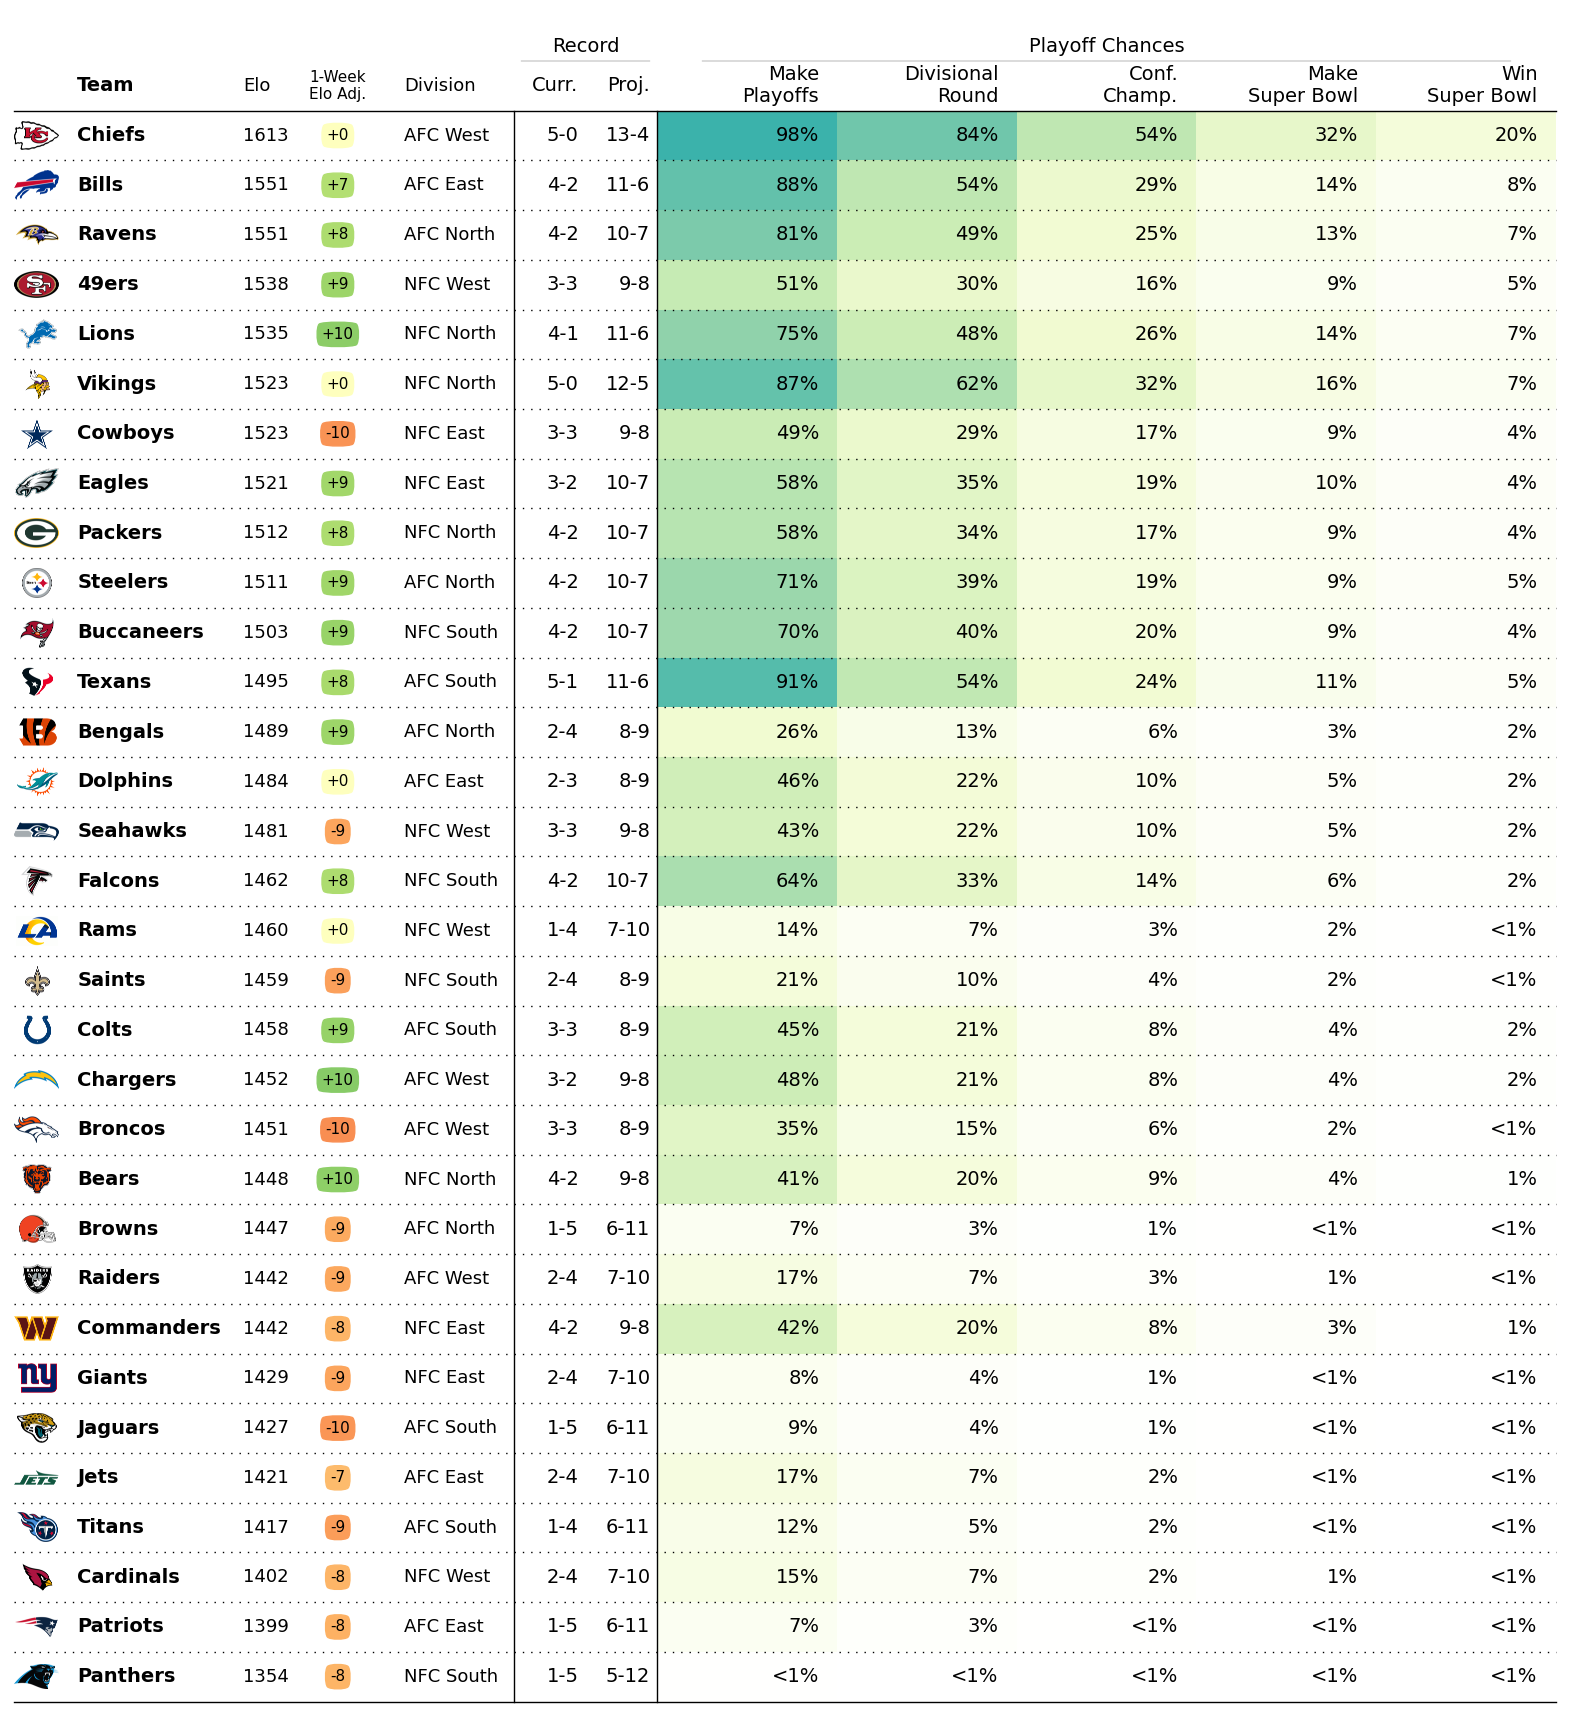

In [23]:
plt.rcParams["font.family"] = ["DejaVu Sans"]
plt.rcParams["savefig.bbox"] = "tight"

fig, ax = plt.subplots(figsize=(20, 22))

table = Table(
    season_long_projections,
    column_definitions=col_defs,
    row_dividers=True,
    footer_divider=True,
    ax=ax,
    textprops={"fontsize": 14},
    row_divider_kw={"linewidth": 1, "linestyle": (0, (1, 5))},
    col_label_divider_kw={"linewidth": 1, "linestyle": "-"},
    column_border_kw={"linewidth": 1, "linestyle": "-"},
)
# plt.show()
fig.savefig(f"../../data/images/2024_playoff_table_wk{final_actual_week}.png", facecolor=ax.get_facecolor(), dpi=200)